# EDA for Tel Aviv for Micro Mobility

* Check number of accidents per quarter
    * Compare to number of total accidents excluding micro mobility
    * Ratio of number accident
* Bicycle Path Length in relation to Quarter area.
    * Pearson Correlation between length of BP and number of accidents for each quarter
* Graph of number of accidents per quarter and total length of bicycle path in regards to time 
    * Normalize by population in Tel Aviv
    * Scatter plot x is length of BP, y number of accidents.
        * One general scatter plot
        * Each quarter a specific plot
    * Scatter plot but with accidents that are severe
* Compare BP length to streets length


Things for next time 04/09/2024
* add sources of data
* check accuracy of accidents, עיגון column "location accuracy"
    * % in each Quarter 
* per quarter accidents for total share of bp in relation to streets length
* get data of shops and gardens

Create specific graphs:
* line graph, instead of bp lane length the share over the years
    * severe accidents
    * general for all the city, not by quarter
    * filter for accident accuracy
* Add units in graphs

15/9/2024 current next step:

* Fix street names in **Checking how many streets pass through multiple quarters.**

        Currently I have some streets like שאול המלך that don't align with שד שאול המלך
        Also streets like '1184', where I'm not sure if it exists in accidents or not.


In [1]:
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
import pandas as pd
import numpy as np
from IPython.display import Image, display

### Loading Quarters Data

In [2]:
ta_q = gpd.read_file("./csv_tables/TA_Quaters_UTM/Quarters.shp")
ta_q.oidrova = pd.to_numeric(ta_q.oidrova, downcast='integer')
ta_q.krova = pd.to_numeric(ta_q.krova, downcast='integer')
display(ta_q.crs)
ta_q

<Projected CRS: EPSG:32636>
Name: WGS 84 / UTM zone 36N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 30°E and 36°E, northern hemisphere between equator and 84°N, onshore and offshore. Belarus. Cyprus. Egypt. Ethiopia. Finland. Israel. Jordan. Kenya. Lebanon. Moldova. Norway. Russian Federation. Saudi Arabia. Sudan. Syria. Türkiye (Turkey). Uganda. Ukraine.
- bounds: (30.0, 0.0, 36.0, 84.0)
Coordinate Operation:
- name: UTM zone 36N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

oidrova  krova           dateimport     ShapeArea  \
0        1      1  01/12/2015 02:28:14  1.301654e+07   
1        2      2  01/12/2015 02:28:14  8.013404e+06   
2        3      3  01/12/2015 02:28:14  3.380430e+06   
3        4      4  01/12/2015 02:28:14  4.510255e+06   
4        5      6  01/12/2015 02:28:14  2.089044e+06   
5        6      9  01/12/2015 02:28:14  7.879856e+06   
6        7      5  01/12/2015 02:28:14  3.024297e+06   
7        8      8  01/12/2015 02:28:14  3.420996e+06   
8        9      7  01/12/2015 02:28:14  6.343551e+06   

                                            geometry  
0  POLYGON ((670795.655 3555762.452, 670797.577 3...  
1  POLYGON ((672021.029 3553364.492, 672014.690 3...  
2  POLYGON ((668311.070 3552547.701, 668311.229 3...  
3  POLYGON ((670771.828 3552544.564, 670771.584 3...  
4  POLYGON ((668160.048 3550196.192, 668162.425 3...  
5  POLYGON ((668811.121 3546980.368, 668808.698 3...  
6  POLYGON ((666698.783 3550619.396, 666701.339 3...  
7  POLYGON ((667954.133 3548820.374, 667956.725 3...  
8  POLYGON ((665854.540 3548193.053, 665868.137 3...

#### Plotting Quarters

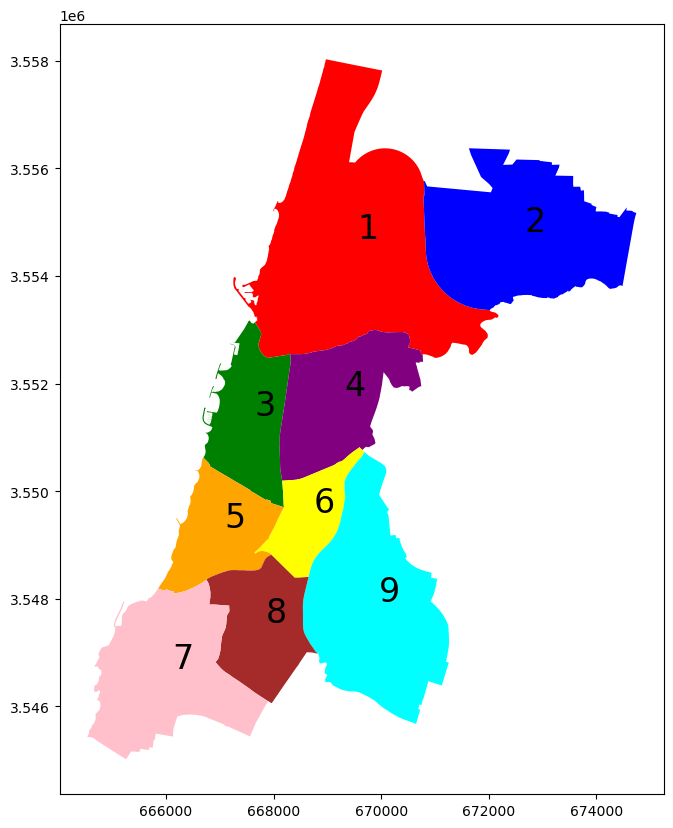

In [3]:
ta_q['index'] = ta_q.index

# Define a list of colors
color_map = {
    1: 'red', 2: 'blue', 3: 'green', 4: 'purple',
    5: 'orange', 6: 'yellow', 7: 'pink', 8: 'brown', 9: 'cyan'
}

# Basic plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Plot each shape with a different color from the list
for idx, row in ta_q.iterrows():
    color = color_map[row['krova']]  # Cycle through the colors list
    gpd.GeoSeries([row['geometry']]).plot(ax=ax, color=color)

    # Get the centroid of the polygon to place the text
    centroid = row['geometry'].centroid
    ax.annotate(text=row['krova'], xy=(centroid.x, centroid.y), 
                xytext=(3, 3), textcoords="offset points",
                fontsize=24, color='black')

plt.show()

### Loading TA Accidents and TA Micro Mobility Accidents

In [4]:
# Exclude micro mobility
BICYCLE = 15
SCOOTER = 21
E_BICYCLE = 23
micro_m = [SCOOTER, E_BICYCLE, BICYCLE]


In [5]:
# Load original accident data
i_m_h_ta_gdf = gpd.read_parquet('./csv_tables/i_m_h_ta_gdf.parquet')

In [6]:
# Accidents that are not MM
i_m_h_ta_no_mm_gdf = i_m_h_ta_gdf[~(i_m_h_ta_gdf.involve_vehicle_type.isin(micro_m))].copy()

In [7]:
# Accidents that are just MM
i_m_h_ta_mm_gdf =  gpd.read_parquet('./csv_tables/i_m_h_ta_mm_gdf.parquet')
display(i_m_h_ta_mm_gdf.crs)
i_m_h_ta_mm_gdf.head(5)

<Projected CRS: EPSG:32636>
Name: WGS 84 / UTM zone 36N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 30°E and 36°E, northern hemisphere between equator and 84°N, onshore and offshore. Belarus. Cyprus. Egypt. Ethiopia. Finland. Israel. Jordan. Kenya. Lebanon. Moldova. Norway. Russian Federation. Saudi Arabia. Sudan. Syria. Türkiye (Turkey). Uganda. Ukraine.
- bounds: (30.0, 0.0, 36.0, 84.0)
Coordinate Operation:
- name: UTM zone 36N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

accident_id  provider_and_id  provider_code  file_type_police  \
41    2013001368      32013001368              3                 3   
50    2013001742      32013001742              3                 3   
131   2013001350      12013001350              1                 1   
196   2013000147      12013000147              1                 1   
197   2013000147      12013000147              1                 1   

     involved_type involved_type_hebrew  license_acquiring_date  age_group  \
41               2             נהג נפגע                       0          6   
50               2             נהג נפגע                       0          7   
131              2             נהג נפגע                       0          5   
196              2             נהג נפגע                       0          8   
197              2             נהג נפגע                       0          6   

    age_group_hebrew  sex  ... vehicle_attribution  \
41             25-29    1  ...                 1.0   
50             30-34    2  ...                 1.0   
131            20-24    1  ...                 1.0   
196            35-39    1  ...                 1.0   
197            25-29    1  ...                 1.0   

     vehicle_attribution_hebrew seats  total_weight total_weight_hebrew  \
41                       ישראלי  99.0           0.0             לא ידוע   
50                       ישראלי  99.0           0.0             לא ידוע   
131                      ישראלי  99.0           0.0             לא ידוע   
196                      ישראלי  99.0           0.0             לא ידוע   
197                      ישראלי  99.0           0.0             לא ידוע   

     vehicle_damage vehicle_damage_hebrew  urban_intersection  \
41              4.0               אין נזק                 NaN   
50              4.0               אין נזק                 NaN   
131             4.0               אין נזק                 NaN   
196             2.0                בינוני           9110323.0   
197             2.0                בינוני           9110323.0   

           accident_date                        geometry  
41   2013-07-27 01:00:00  POINT (667544.749 3549959.961)  
50   2013-10-07 01:30:00  POINT (667286.918 3548726.540)  
131  2013-08-25 01:00:00  POINT (667023.688 3548785.170)  
196  2013-09-19 00:00:00  POINT (668158.751 3551284.678)  
197  2013-09-19 00:00:00  POINT (668158.751 3551284.678)  

[5 rows x 162 columns]

#### Plotting accidents

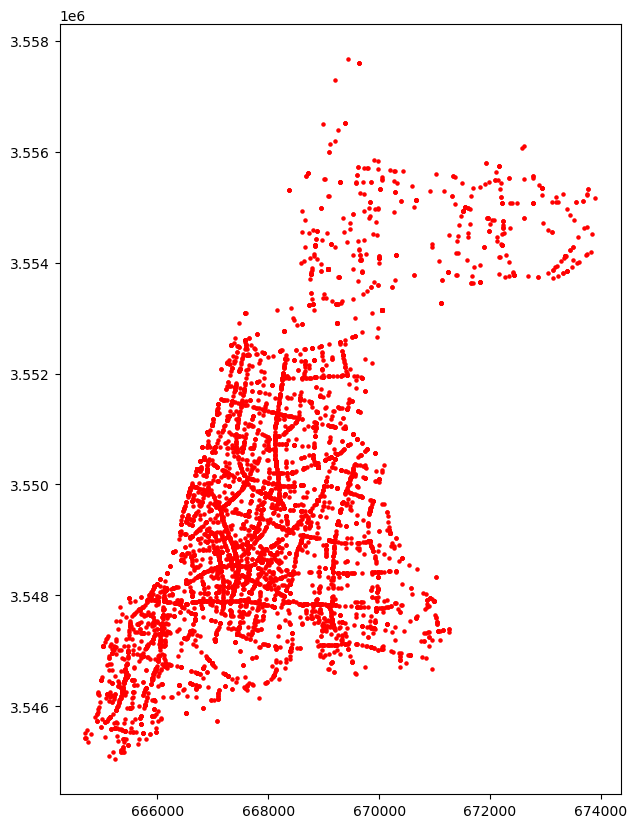

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
i_m_h_ta_mm_gdf.plot(ax=ax, color='red', marker='o', markersize=5 )
plt.show()

### Loading BP

In [9]:
bp_ta_bp_and_meta = gpd.read_parquet('./csv_tables/bp_ta_bp_and_meta.parquet')
bp_ta_bp_and_meta.head(5)

oid_shvil  msorech           dateimport  create_year  \
0          1    95.10  14/08/2024 02:30:05         2012   
1          2   201.14  14/08/2024 02:30:05         2013   
2          3   696.31  14/08/2024 02:30:05         2004   
3          4   659.20  14/08/2024 02:30:05         2018   
4          5   362.67  14/08/2024 02:30:05         2018   

                                   shemmikta create_date  \
0                       נמיר מיוניצ'מן דרומה        None   
1                 פרופס מנמיר עד קדושי השואה        None   
2   יאיר רוזנבלום מאורי צבי גרינברג עד פרופס        None   
3                   קק"ל מנמיר עד חיים לבנון        None   
4  רקנאטי בגינה מקרן קיימת לישראל עד אחימאיר        None   

                                            geometry  width direction  bitzua  \
0  LINESTRING (669823.985 3557373.860, 669855.549...    2.5   דו סטרי    2012   
1  LINESTRING (669232.834 3555478.027, 669169.381...    2.5   דו סטרי    2013   
2  LINESTRING (669232.637 3555478.023, 669249.025...    2.1   דו סטרי    2004   
3  LINESTRING (669354.261 3555417.055, 669410.178...    2.5   דו סטרי    2018   
4  LINESTRING (669946.350 3555344.516, 669962.261...    2.0   דו סטרי    2018   

  miflas date_created  
0   None         None  
1   None         None  
2   None         None  
3  מדרכה         None  
4   None   30/06/2018

#### Checking validity by lotting Quarters, Micro Mobility Accidents  and BP

In [10]:
i_m_h_ta_mm_gdf.crs

<Projected CRS: EPSG:32636>
Name: WGS 84 / UTM zone 36N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 30°E and 36°E, northern hemisphere between equator and 84°N, onshore and offshore. Belarus. Cyprus. Egypt. Ethiopia. Finland. Israel. Jordan. Kenya. Lebanon. Moldova. Norway. Russian Federation. Saudi Arabia. Sudan. Syria. Türkiye (Turkey). Uganda. Ukraine.
- bounds: (30.0, 0.0, 36.0, 84.0)
Coordinate Operation:
- name: UTM zone 36N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

#### Plotting accidents with BP and Quarters

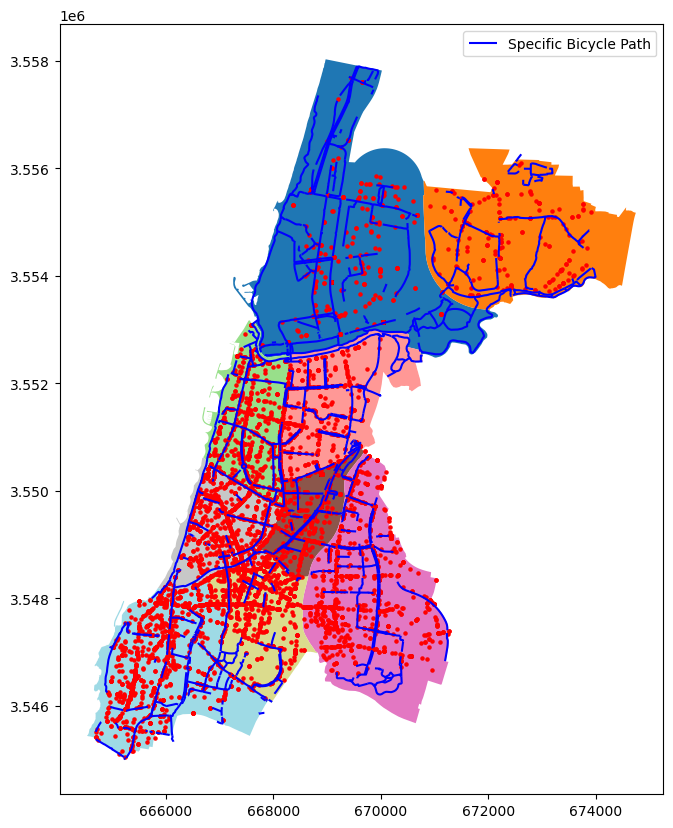

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))

ta_q.plot(ax=ax, cmap='tab20', legend=True,)
bp_ta_bp_and_meta.plot(ax=ax, color='blue', label='Specific Bicycle Path')
i_m_h_ta_mm_gdf.plot(ax=ax, color='red', marker='o', markersize=5 )

plt.legend()
plt.show()

## Loading streets data


In [12]:
ta_streets = gpd.read_file('./csv_tables/TA_streets_20240724_031704/Streets.shp')
ta_streets

oidrechov  krechov      trechov         shemangli  mslamas  tsug  \
0           1.0    915.0  הרוגי מלכות   HARUGEY MALKHOT    336.0  רחוב   
1           2.0      0.0            0            UKNOWN      0.0  רחוב   
2           3.0    265.0      אמסטרדם         AMSTERDAM    516.0  רחוב   
3           4.0    644.0    אלון יגאל      YIG'AL ALLON   2524.0  רחוב   
4           5.0    634.0      מרגולין          MARGOLIN   2649.0  רחוב   
...         ...      ...          ...               ...      ...   ...   
8874     9851.0   3007.0   שבטי ישראל  SHIVTEY YISRA'EL   1983.0  רחוב   
8875     9852.0   3058.0  אבינרי יצחק           AVINERY   2027.0  רחוב   
8876     9853.0   3058.0  אבינרי יצחק           AVINERY   2027.0  רחוב   
8877     9855.0   3907.0         3907              None   1703.0  רחוב   
8878     9857.0     34.0        מטלון           MATALON   2327.0  רחוב   

      kkivun   UniqueId       shemarvit  kreka  \
0        0.0  507-10001       قتل مملكة  100.0   
1        3.0  507-10002            None  100.0   
2        1.0  507-10003        أمستردام  100.0   
3        0.0  507-10004      ألون ييغال  200.0   
4        1.0  507-10005        مارغولين  100.0   
...      ...        ...             ...    ...   
8874     0.0  507-17843   قبائل إسرائيل  100.0   
8875     0.0  507-20562  Avinri Yitzhak  100.0   
8876     0.0  507-20563  Avinri Yitzhak  100.0   
8877     0.0  507-21960            3907  100.0   
8878     0.0  507-21966         ميتالون  100.0   

                                               geometry  
0     LINESTRING (672865.880 3554095.253, 672895.216...  
1     LINESTRING (666990.498 3551436.940, 667065.337...  
2     LINESTRING (667879.712 3551424.162, 667940.741...  
3     LINESTRING (669570.036 3550420.535, 669581.404...  
4     LINESTRING (669329.153 3548322.758, 669409.403...  
...                                                 ...  
8874  LINESTRING (665771.816 3547023.159, 665760.256...  
8875  LINESTRING (665585.719 3547178.152, 665627.936...  
8876  LINESTRING (665700.142 3547064.296, 665759.119...  
8877  LINESTRING (665087.059 3546677.092, 665075.120...  
8878  LINESTRING (666917.433 3548291.622, 666930.486...  

[8879 rows x 11 columns]

#### Checking street length validity with google maps

In [13]:
ta_streets[ta_streets.shemangli == 'MARGOLIN'].geometry.length.sum()

690.5226685950398

#### Plotting streets with BP and MM Accidents and  Quarters

In [14]:

# fig, ax = plt.subplots(figsize=(30, 30))

# ta_streets.plot(ax=ax, cmap='tab20', legend=True, label='Specific Bicycle Path')
# ta_q.plot(ax=ax, cmap='tab20', legend=True,)
# bp_ta_bp_and_meta.plot(ax=ax, color='blue', label='Specific Bicycle Path')
# i_m_h_ta_mm_gdf.plot(ax=ax, color='black', marker='o', markersize=15 )


# plt.legend()
# plt.show()

Checking Location Accuracy

In [17]:
i_m_h_ta_gdf.location_accuracy.value_counts(normalize=True)

location_accuracy
1    0.512342
3    0.424395
2    0.063263
Name: proportion, dtype: float64

In [18]:
i_m_h_ta_mm_gdf.location_accuracy.value_counts(normalize=True)

location_accuracy
1    0.597338
3    0.379679
2    0.022983
Name: proportion, dtype: float64

In [19]:
i_m_h_ta_mm_gdf[i_m_h_ta_mm_gdf.accident_year.isin([2018,2019,2020,2021,2022,2023])].location_accuracy.value_counts(normalize=True)

location_accuracy
1    0.644453
3    0.335212
2    0.020334
Name: proportion, dtype: float64

1 = accurate coordinates<br>
2 = city center <br>
3 = street center

What we care is if the accident is accurate or if the accident is in the street center, why?

If the accident is in it's actual coordinates or if it's in the street center then that means it's in the quarter.

But a street can extend outside the quarter, so I need to make sure how many street intersect other quarters.

Currently I want to check street in 2 = city center, and will probably drop them.

In [16]:
i_m_h_ta_gdf[i_m_h_ta_gdf.location_accuracy == 2].x.value_counts()

x
180245.0    3094
180264.0    2357
180276.0    1265
178125.0      62
182556.0      55
184617.0      39
181651.0      21
181256.0      18
180108.0      16
184141.0      14
177917.0      13
179039.0      12
180029.0      10
182785.0       9
185394.0       9
184741.0       8
181582.0       6
178949.0       6
180697.0       6
178005.0       5
180219.0       5
184435.0       5
180560.0       3
183426.0       3
181104.0       3
181130.0       2
180368.0       1
181509.0       1
Name: count, dtype: int64

In [17]:
# fig, ax = plt.subplots(figsize=(30, 30))

# ta_streets.plot(ax=ax, cmap='tab20', legend=True, label='Specific Bicycle Path')
# ta_q.plot(ax=ax, cmap='tab20', legend=True,)
# bp_ta_bp_and_meta.plot(ax=ax, color='blue', label='Specific Bicycle Path')
# i_m_h_ta_gdf[i_m_h_ta_gdf.location_accuracy == 2].plot(ax=ax, color='black', marker='o', markersize=15 )


# plt.legend()
# plt.show()

We should drop **location_accuracy** 2

---

Lets check **location_accuracy** 3

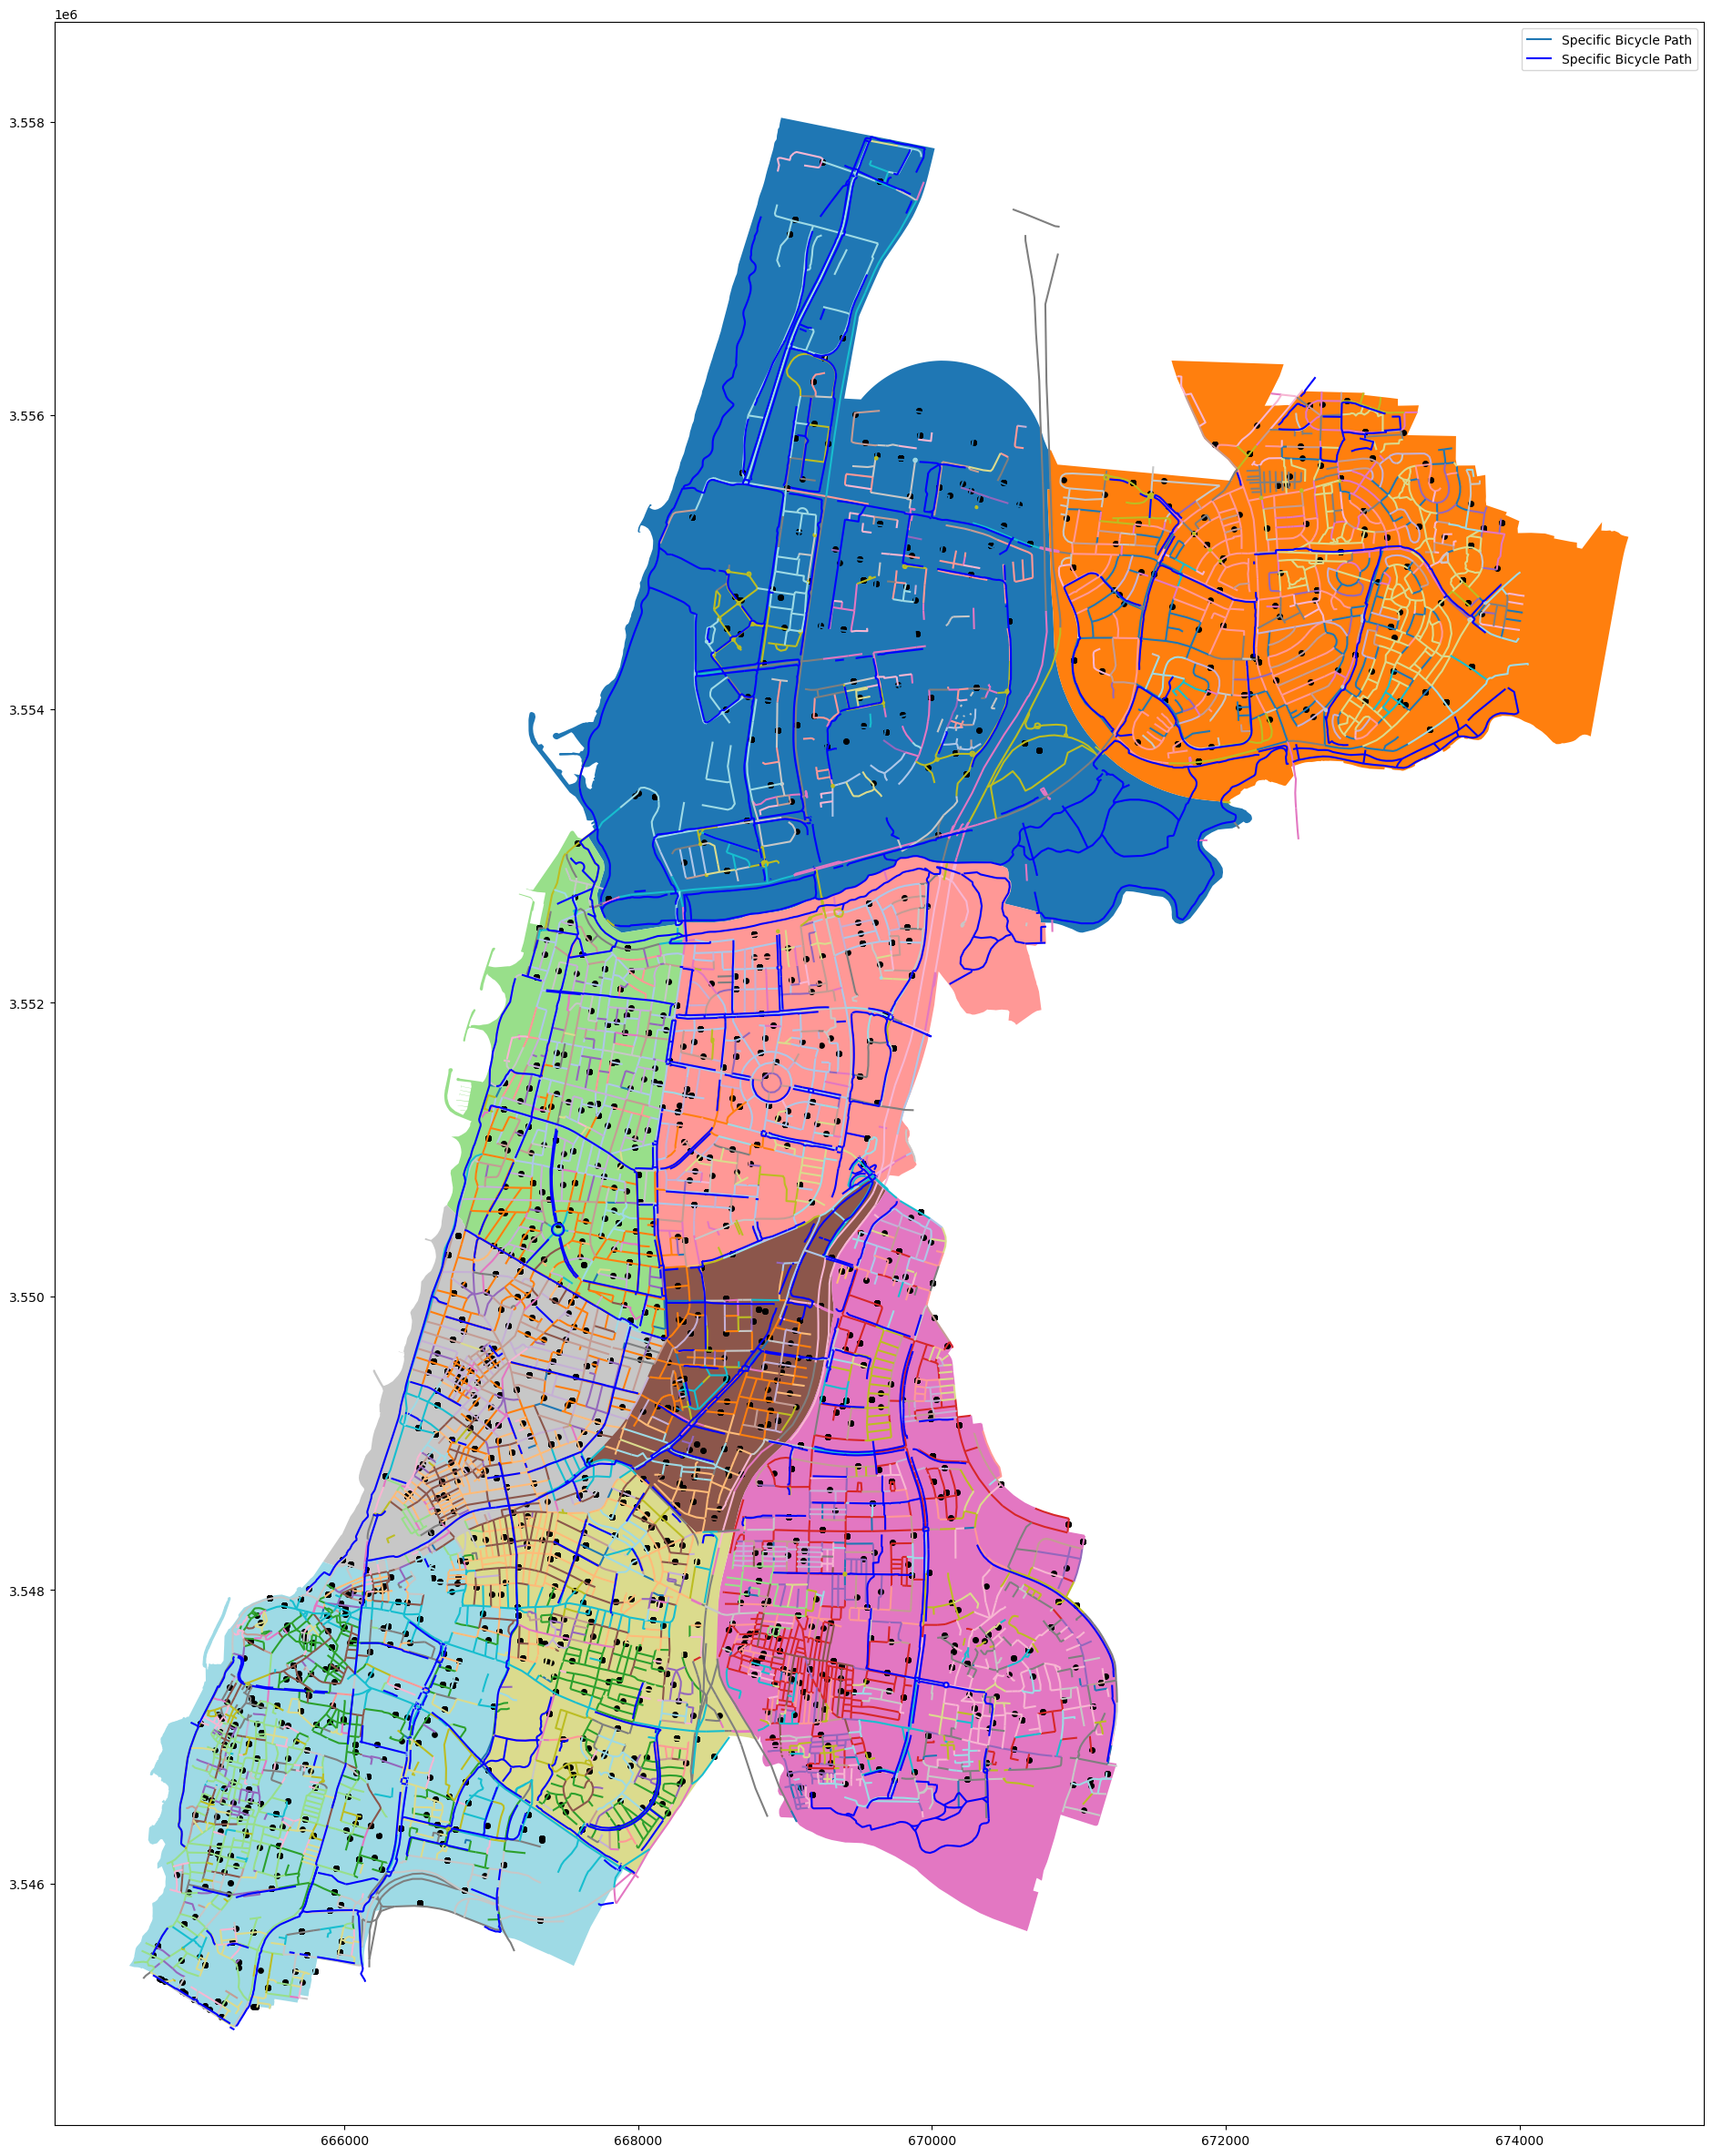

In [18]:
# fig, ax = plt.subplots(figsize=(30, 30))

# ta_streets.plot(ax=ax, cmap='tab20', legend=True, label='Specific Bicycle Path')
# ta_q.plot(ax=ax, cmap='tab20', legend=True,)
# bp_ta_bp_and_meta.plot(ax=ax, color='blue', label='Specific Bicycle Path')
# i_m_h_ta_gdf[i_m_h_ta_gdf.location_accuracy == 3].plot(ax=ax, color='black', marker='o', markersize=15 )


# plt.legend()
# plt.show()



Lets check how many streets intersect other quarters.

We will use streets_in_q that is created later on.

## Feature Engineering 

**BP and Accidents**<br>

    Adding cumulative BP and Cumulative accidents for each quarter

for each quarter:
* Get the area of each quarter
* get the length of all the BP in the quarter
* get the length of all the streets in the quarter

**Streets** 

    Adding total streets length for each quarter 
Side Note: I would do for each street but
* there is little data 
* data regarding which street is open is missing 
I don't think plotting this will be beneficial

Pearson Correlation between length of BP and number of accidents for each quarter

In [19]:
bp_ta_bp_and_meta

oid_shvil  msorech           dateimport  create_year  \
0            1    95.10  14/08/2024 02:30:05         2012   
1            2   201.14  14/08/2024 02:30:05         2013   
2            3   696.31  14/08/2024 02:30:05         2004   
3            4   659.20  14/08/2024 02:30:05         2018   
4            5   362.67  14/08/2024 02:30:05         2018   
..         ...      ...                  ...          ...   
866        462   197.41  14/08/2024 02:30:05         2014   
867        463  2112.94  14/08/2024 02:30:05           -1   
868        464    44.95  14/08/2024 02:30:05           -1   
869        465   112.12  14/08/2024 02:30:05           -1   
870        466    71.58  14/08/2024 02:30:05           -1   

                                     shemmikta create_date  \
0                         נמיר מיוניצ'מן דרומה        None   
1                   פרופס מנמיר עד קדושי השואה        None   
2     יאיר רוזנבלום מאורי צבי גרינברג עד פרופס        None   
3                     קק"ל מנמיר עד חיים לבנון        None   
4    רקנאטי בגינה מקרן קיימת לישראל עד אחימאיר        None   
..                                         ...         ...   
866                שביל המוביל למרכז יצחק רבין        None   
867                                       None        None   
868                                       None        None   
869                                       None        None   
870                                       None        None   

                                              geometry  width direction  \
0    LINESTRING (669823.985 3557373.860, 669855.549...    2.5   דו סטרי   
1    LINESTRING (669232.834 3555478.027, 669169.381...    2.5   דו סטרי   
2    LINESTRING (669232.637 3555478.023, 669249.025...    2.1   דו סטרי   
3    LINESTRING (669354.261 3555417.055, 669410.178...    2.5   דו סטרי   
4    LINESTRING (669946.350 3555344.516, 669962.261...    2.0   דו סטרי   
..                                                 ...    ...       ...   
866  LINESTRING (669777.502 3553114.882, 669733.916...    NaN      None   
867  LINESTRING (670193.904 3552876.389, 670151.903...    NaN      None   
868  LINESTRING (669398.890 3552674.103, 669398.284...    NaN      None   
869  LINESTRING (668324.626 3551551.690, 668319.918...    NaN      None   
870  LINESTRING (668433.941 3550240.154, 668441.188...    NaN      None   

     bitzua miflas date_created  
0      2012   None         None  
1      2013   None         None  
2      2004   None         None  
3      2018  מדרכה         None  
4      2018   None   30/06/2018  
..      ...    ...          ...  
866    2014   None         None  
867      -1   None         None  
868      -1   None         None  
869      -1   None         None  
870      -1   None         None  

[871 rows x 12 columns]

### BP Feature Engineering 

#### Creating Cumulative BP with Accidents and Quarter

In [20]:
bp_ta_bp_and_meta['bp_length'] = bp_ta_bp_and_meta.geometry.length

In [21]:
# get all the bp in a quarter
bp_in_q = gpd.sjoin(bp_ta_bp_and_meta[['oid_shvil','shemmikta','bp_length','geometry','bitzua']], ta_q[['krova', 'geometry']], how='inner', predicate='intersects')

# We have more rows then original bp_ta_bp_and_meta since we have duplication and since
# since there are 47 duplicates(a bit ore then 5%) and most of them are on the same q, we can drop them
bp_in_q = bp_in_q.drop_duplicates(subset=['bp_length'])
bp_in_q

oid_shvil                                  shemmikta    bp_length  \
0            1                       נמיר מיוניצ'מן דרומה    95.089688   
1            2                 פרופס מנמיר עד קדושי השואה   201.128828   
2            3   יאיר רוזנבלום מאורי צבי גרינברג עד פרופס   696.261026   
3            4                   קק"ל מנמיר עד חיים לבנון   659.153296   
4            5  רקנאטי בגינה מקרן קיימת לישראל עד אחימאיר   362.644518   
..         ...                                        ...          ...   
866        462                שביל המוביל למרכז יצחק רבין   197.392781   
867        463                                       None  2112.772412   
868        464                                       None    44.950912   
869        465                                       None   112.108111   
870        466                                       None    71.575372   

                                              geometry  bitzua  index_right  \
0    LINESTRING (669823.985 3557373.860, 669855.549...    2012            0   
1    LINESTRING (669232.834 3555478.027, 669169.381...    2013            0   
2    LINESTRING (669232.637 3555478.023, 669249.025...    2004            0   
3    LINESTRING (669354.261 3555417.055, 669410.178...    2018            0   
4    LINESTRING (669946.350 3555344.516, 669962.261...    2018            0   
..                                                 ...     ...          ...   
866  LINESTRING (669777.502 3553114.882, 669733.916...    2014            0   
867  LINESTRING (670193.904 3552876.389, 670151.903...      -1            3   
868  LINESTRING (669398.890 3552674.103, 669398.284...      -1            3   
869  LINESTRING (668324.626 3551551.690, 668319.918...      -1            3   
870  LINESTRING (668433.941 3550240.154, 668441.188...      -1            4   

     krova  
0        1  
1        1  
2        1  
3        1  
4        1  
..     ...  
866      1  
867      4  
868      4  
869      4  
870      6  

[869 rows x 7 columns]

Making sure that BP that have no year of creation (bitzua) are unique and not actually related to other BP<br>
If they are unique, drop them.

In [22]:
bp_in_q[bp_in_q.oid_shvil.isin(bp_in_q[bp_in_q.bitzua == -1].oid_shvil)]

oid_shvil                       shemmikta    bp_length  \
818        419                            None     7.148114   
819        420                            None   235.178823   
820        421                            None   110.085315   
821        422                            None   135.646550   
825        426       אינשטיין מלישנסקי עד הגשר   319.429381   
828        429                            None    74.291330   
829        430                            None    28.706871   
830        431                            None     5.463124   
831        432                            None    19.641170   
832        433                            None    29.649964   
833        434                            None     7.408510   
835        436                            None    17.048499   
836        437                           שניצר   435.287728   
837        438                            None    55.722874   
838        439                     קדושי השואה   554.091195   
839        440                            None     9.411587   
840        441                            None     7.802132   
841        442                            None     6.917799   
842        443                            None     7.652299   
849        449                            None    24.925195   
851        451                            None   237.200398   
858        456  הגדוד העברי מצ'לנוב עד הר ציון   172.749519   
862        458                            None   157.466420   
864        460           חנה רובינא גדה דרומית   235.462831   
867        463                            None  2112.772412   
868        464                            None    44.950912   
869        465                            None   112.108111   
870        466                            None    71.575372   

                                              geometry  bitzua  index_right  \
818  LINESTRING (668405.407 3554224.806, 668398.271...      -1            0   
819  LINESTRING (668328.569 3552403.104, 668215.470...      -1            2   
820  LINESTRING (669671.803 3553011.534, 669678.363...      -1            3   
821  LINESTRING (670743.348 3552413.244, 670743.408...      -1            3   
825  LINESTRING (668722.847 3554258.059, 668645.585...      -1            0   
828  LINESTRING (669114.211 3553307.829, 669119.029...      -1            0   
829  LINESTRING (669139.697 3553260.352, 669168.290...      -1            0   
830  LINESTRING (669177.650 3553267.796, 669173.921...      -1            0   
831  LINESTRING (669171.699 3553253.385, 669172.367...      -1            0   
832  LINESTRING (669174.747 3553223.387, 669162.198...      -1            0   
833  LINESTRING (669138.878 3553222.759, 669133.694...      -1            0   
835  LINESTRING (668727.210 3555599.430, 668722.695...      -1            0   
836  LINESTRING (669177.008 3556117.864, 669172.205...      -1            0   
837  LINESTRING (669137.693 3555857.832, 669096.634...      -1            0   
838  LINESTRING (669077.515 3556061.715, 669071.257...      -1            0   
839  LINESTRING (669006.054 3556456.529, 669014.758...      -1            0   
840  LINESTRING (669026.431 3556449.754, 669034.124...      -1            0   
841  LINESTRING (669018.101 3556491.192, 669024.660...      -1            0   
842  LINESTRING (669037.420 3556484.549, 669044.631...      -1            0   
849  LINESTRING (667330.906 3551499.313, 667306.793...      -1            2   
851  LINESTRING (667372.545 3552078.483, 667454.736...      -1            2   
858  LINESTRING (667661.811 3548450.710, 667698.700...      -1            7   
862  LINESTRING (668569.064 3553991.289, 668557.508...      -1            0   
864  LINESTRING (671517.200 3555437.604, 671521.514...      -1            1   
867  LINESTRING (670193.904 3552876.389, 670151.903...      -1            3   
868  LINESTRING (669398.890 3552674.103, 669398.284...      -1            3   
869  LINESTRING (668324.626 3551551.690, 668

In [23]:
# Making sure that not just oid is unique also name of bp
bp_in_q[bp_in_q.shemmikta.isin(bp_in_q[bp_in_q.bitzua == -1].dropna().shemmikta)]

oid_shvil                       shemmikta   bp_length  \
825        426       אינשטיין מלישנסקי עד הגשר  319.429381   
836        437                           שניצר  435.287728   
838        439                     קדושי השואה  554.091195   
858        456  הגדוד העברי מצ'לנוב עד הר ציון  172.749519   
864        460           חנה רובינא גדה דרומית  235.462831   

                                              geometry  bitzua  index_right  \
825  LINESTRING (668722.847 3554258.059, 668645.585...      -1            0   
836  LINESTRING (669177.008 3556117.864, 669172.205...      -1            0   
838  LINESTRING (669077.515 3556061.715, 669071.257...      -1            0   
858  LINESTRING (667661.811 3548450.710, 667698.700...      -1            7   
864  LINESTRING (671517.200 3555437.604, 671521.514...      -1            1   

     krova  
825      1  
836      1  
838      1  
858      8  
864      2

Bitzua with -1 is unique so I drop them all.

In [24]:
bp_in_q_bitzua_no_na = bp_in_q[~bp_in_q.oid_shvil.isin(bp_in_q[bp_in_q.bitzua == -1].oid_shvil)].copy()
bp_in_q_bitzua_no_na

oid_shvil                                  shemmikta   bp_length  \
0            1                       נמיר מיוניצ'מן דרומה   95.089688   
1            2                 פרופס מנמיר עד קדושי השואה  201.128828   
2            3   יאיר רוזנבלום מאורי צבי גרינברג עד פרופס  696.261026   
3            4                   קק"ל מנמיר עד חיים לבנון  659.153296   
4            5  רקנאטי בגינה מקרן קיימת לישראל עד אחימאיר  362.644518   
..         ...                                        ...         ...   
860        457        יובל נאמן מלוי אשכול עד אייזיק שטרן   19.522751   
861        457        יובל נאמן מלוי אשכול עד אייזיק שטרן  135.518261   
863        459      יהודה עמיחי מיובל נאמן עד אייזיק שטרן  146.910140   
865        461                     פארק גני יהושוע (רוקח)  325.943424   
866        462                שביל המוביל למרכז יצחק רבין  197.392781   

                                              geometry  bitzua  index_right  \
0    LINESTRING (669823.985 3557373.860, 669855.549...    2012            0   
1    LINESTRING (669232.834 3555478.027, 669169.381...    2013            0   
2    LINESTRING (669232.637 3555478.023, 669249.025...    2004            0   
3    LINESTRING (669354.261 3555417.055, 669410.178...    2018            0   
4    LINESTRING (669946.350 3555344.516, 669962.261...    2018            0   
..                                                 ...     ...          ...   
860  LINESTRING (668688.687 3554091.847, 668685.107...    2024            0   
861  LINESTRING (668612.378 3554202.585, 668617.080...    2024            0   
863  LINESTRING (668685.107 3554072.655, 668682.157...    2024            0   
865  LINESTRING (670629.535 3553186.344, 670669.513...    2024            0   
866  LINESTRING (669777.502 3553114.882, 669733.916...    2014            0   

     krova  
0        1  
1        1  
2        1  
3        1  
4        1  
..     ...  
860      1  
861      1  
863      1  
865      1  
866      1  

[841 rows x 7 columns]

In [25]:
# Define the range for krova and bitzua
krova_range = range(1, 10)  # 1 to 9 inclusive
bitzua_range = range(2000, 2025)  # 2014 to 2023 inclusive

# Create a MultiIndex
index = pd.MultiIndex.from_product([krova_range, bitzua_range], names=['krova', 'bitzua'])

# Create a DataFrame with the MultiIndex
# Initialize with random data or zeros
bp_krova = pd.DataFrame( index=index)
bp_krova['bp_length'] = 0
# Display the DataFrame
bp_krova

bp_length
krova bitzua           
1     2000            0
      2001            0
      2002            0
      2003            0
      2004            0
...                 ...
9     2020            0
      2021            0
      2022            0
      2023            0
      2024            0

[225 rows x 1 columns]

In [26]:
# Ensure the DataFrame is sorted by 'krova' and 'year'
bp_in_q_bitzua_no_na_sort = bp_in_q_bitzua_no_na.sort_values(by=['krova', 'bitzua'])

# Calculate the cumulative sum
bp_krova['bp_length'] = bp_in_q_bitzua_no_na_sort.groupby(['krova', 'bitzua'])['bp_length'].sum()

bp_krova

bp_length
krova bitzua             
1     2000    1431.567191
      2001            NaN
      2002            NaN
      2003            NaN
      2004    4713.852363
...                   ...
9     2020    2081.540059
      2021    1509.641511
      2022     537.031651
      2023     171.426575
      2024            NaN

[225 rows x 1 columns]

In [27]:
bp_krova['cum_bp_length'] = bp_krova.groupby('krova')['bp_length'].cumsum()
bp_krova

bp_length  cum_bp_length
krova bitzua                            
1     2000    1431.567191    1431.567191
      2001            NaN            NaN
      2002            NaN            NaN
      2003            NaN            NaN
      2004    4713.852363    6145.419554
...                   ...            ...
9     2020    2081.540059   20832.869564
      2021    1509.641511   22342.511075
      2022     537.031651   22879.542727
      2023     171.426575   23050.969302
      2024            NaN            NaN

[225 rows x 2 columns]

In [28]:
# Forward fill NaN values with the previous non-NaN value for both columns
bp_krova['bp_length'] = bp_krova['bp_length'].ffill()
bp_krova['cum_bp_length'] = bp_krova['cum_bp_length'].ffill()

# Display the updated DataFrame
bp_krova


bp_length  cum_bp_length
krova bitzua                            
1     2000    1431.567191    1431.567191
      2001    1431.567191    1431.567191
      2002    1431.567191    1431.567191
      2003    1431.567191    1431.567191
      2004    4713.852363    6145.419554
...                   ...            ...
9     2020    2081.540059   20832.869564
      2021    1509.641511   22342.511075
      2022     537.031651   22879.542727
      2023     171.426575   23050.969302
      2024     171.426575   23050.969302

[225 rows x 2 columns]

In [29]:
bp_krova.xs(4, level='krova')

bp_length  cum_bp_length
bitzua                            
2000    3652.646051    3652.646051
2001    3652.646051    3652.646051
2002     904.620455    4557.266506
2003     904.620455    4557.266506
2004    5954.678368   10511.944875
2005    5954.678368   10511.944875
2006    5954.678368   10511.944875
2007    5954.678368   10511.944875
2008    5954.678368   10511.944875
2009    5954.678368   10511.944875
2010    5954.678368   10511.944875
2011    5954.678368   10511.944875
2012    1045.363666   11557.308541
2013     502.869287   12060.177828
2014     308.988817   12369.166646
2015     308.988817   12369.166646
2016    1701.036386   14070.203032
2017     303.627379   14373.830411
2018    1196.270724   15570.101135
2019     451.048317   16021.149452
2020    1264.659531   17285.808984
2021    4489.535020   21775.344004
2022    3023.563053   24798.907057
2023    3023.563053   24798.907057
2024    3023.563053   24798.907057

So we have
* bp length in each q over the years
* bp length cumulative in each q over the years
* q area


We also want number of accidents for each q over the years.<br>
For that I need:
* get the years of accidents in each q
* get the years of accidents for mm in in each q
* get the number of accidents in each q over the years
* get the number of mm accident in each q over the years

Then filter the bp_krova with the years.


Making sure we are not missing something in regards of years

In [30]:
# Spatial join of TA accidents and Quarters
i_m_h_ta_quarters_gdf = gpd.sjoin(i_m_h_ta_gdf, ta_q[['krova', 'geometry']], how='inner', predicate='intersects')
i_m_h_ta_no_mm_quarters_gdf = gpd.sjoin(i_m_h_ta_no_mm_gdf, ta_q[['krova', 'geometry']], how='inner', predicate='intersects')
i_m_h_ta_mm_quarters_gdf = gpd.sjoin(i_m_h_ta_mm_gdf, ta_q[['krova', 'geometry']], how='inner', predicate='intersects')

In [31]:
# 
i_m_h_ta_q_gb_krova = pd.DataFrame(i_m_h_ta_quarters_gdf.groupby(['krova', 'accident_year']).size(), columns=['all_accident_cnt'])
i_m_h_ta_no_mm_q_gb_krova = pd.DataFrame(i_m_h_ta_no_mm_quarters_gdf.groupby(['krova', 'accident_year']).size(),columns=['no_mm_accident_cnt'])
i_m_h_ta_mm_q_gb_krova = pd.DataFrame(i_m_h_ta_mm_quarters_gdf.groupby(['krova', 'accident_year']).size(),columns=['mm_accident_cnt'])
i_m_h_ta_q_gb_krova

all_accident_cnt
krova accident_year                  
1     2013                       1399
      2014                       1109
      2015                       1289
      2016                       1159
      2017                       1108
...                               ...
9     2020                       1094
      2021                       1157
      2022                       1187
      2023                       1088
      2024                        422

[108 rows x 1 columns]

In [32]:
# trying to assign the accident_cnt to bp_krova
bp_krova['all_acc_cnt'] = 0
bp_krova['no_mm_acc_cnt'] = 0
bp_krova['mm_acc_cnt'] = 0

bp_krova['all_acc_cnt']   = i_m_h_ta_q_gb_krova['all_accident_cnt']
bp_krova['no_mm_acc_cnt'] = i_m_h_ta_no_mm_q_gb_krova['no_mm_accident_cnt']
bp_krova['mm_acc_cnt']    = i_m_h_ta_mm_q_gb_krova['mm_accident_cnt']
bp_krova

bp_length  cum_bp_length  all_acc_cnt  no_mm_acc_cnt  \
krova bitzua                                                           
1     2000    1431.567191    1431.567191          NaN            NaN   
      2001    1431.567191    1431.567191          NaN            NaN   
      2002    1431.567191    1431.567191          NaN            NaN   
      2003    1431.567191    1431.567191          NaN            NaN   
      2004    4713.852363    6145.419554          NaN            NaN   
...                   ...            ...          ...            ...   
9     2020    2081.540059   20832.869564       1094.0          990.0   
      2021    1509.641511   22342.511075       1157.0         1042.0   
      2022     537.031651   22879.542727       1187.0         1067.0   
      2023     171.426575   23050.969302       1088.0          981.0   
      2024     171.426575   23050.969302        422.0          383.0   

              mm_acc_cnt  
krova bitzua              
1     2000           NaN  
      2001           NaN  
      2002           NaN  
      2003           NaN  
      2004           NaN  
...                  ...  
9     2020         104.0  
      2021         115.0  
      2022         120.0  
      2023         107.0  
      2024          39.0  

[225 rows x 5 columns]

In [33]:
bp_krova.xs(3, level='krova')

bp_length  cum_bp_length  all_acc_cnt  no_mm_acc_cnt  mm_acc_cnt
bitzua                                                                    
2000    2393.581055    2393.581055          NaN            NaN         NaN
2001    2393.581055    2393.581055          NaN            NaN         NaN
2002     914.986474    3308.567529          NaN            NaN         NaN
2003     914.986474    3308.567529          NaN            NaN         NaN
2004    2527.949327    5836.516856          NaN            NaN         NaN
2005    2527.949327    5836.516856          NaN            NaN         NaN
2006    2527.949327    5836.516856          NaN            NaN         NaN
2007    2527.949327    5836.516856          NaN            NaN         NaN
2008    2527.949327    5836.516856          NaN            NaN         NaN
2009    2527.949327    5836.516856          NaN            NaN         NaN
2010    2527.949327    5836.516856          NaN            NaN         NaN
2011    2527.949327    5836.516856          NaN            NaN         NaN
2012    2608.205283    8444.722139          NaN            NaN         NaN
2013    2608.205283    8444.722139       1153.0         1112.0        41.0
2014    2608.205283    8444.722139       1050.0          971.0        79.0
2015    2608.205283    8444.722139       1009.0          956.0        53.0
2016    2608.205283    8444.722139       1077.0          986.0        91.0
2017    2608.205283    8444.722139        944.0          856.0        88.0
2018     257.426020    8702.148159        864.0          780.0        84.0
2019     257.426020    8702.148159        726.0          631.0        95.0
2020    1176.904473    9879.052632        636.0          552.0        84.0
2021    4378.072371   14257.125003        654.0          550.0       104.0
2022    1171.167498   15428.292501        600.0          521.0        79.0
2023    1171.167498   15428.292501        506.0          441.0        65.0
2024    1171.167498   15428.292501        211.0          180.0        31.0

In [34]:
# Filter the DataFrame to keep only rows where bitzua is 2013 or greater
bp_krova_filtered = bp_krova.loc[bp_krova.index.get_level_values('bitzua') >= 2013].copy()

# Display the filtered DataFrame
bp_krova_filtered
bp_krova_filtered.xs(3, level='krova')

bp_length  cum_bp_length  all_acc_cnt  no_mm_acc_cnt  mm_acc_cnt
bitzua                                                                    
2013    2608.205283    8444.722139       1153.0         1112.0        41.0
2014    2608.205283    8444.722139       1050.0          971.0        79.0
2015    2608.205283    8444.722139       1009.0          956.0        53.0
2016    2608.205283    8444.722139       1077.0          986.0        91.0
2017    2608.205283    8444.722139        944.0          856.0        88.0
2018     257.426020    8702.148159        864.0          780.0        84.0
2019     257.426020    8702.148159        726.0          631.0        95.0
2020    1176.904473    9879.052632        636.0          552.0        84.0
2021    4378.072371   14257.125003        654.0          550.0       104.0
2022    1171.167498   15428.292501        600.0          521.0        79.0
2023    1171.167498   15428.292501        506.0          441.0        65.0
2024    1171.167498   15428.292501        211.0          180.0        31.0

In [35]:
# Calculating Cum Sum
bp_krova_filtered['cum_all_acc_cnt'] = bp_krova_filtered.groupby('krova')['all_acc_cnt'].cumsum()
bp_krova_filtered['cum_no_mm_acc_cnt'] = bp_krova_filtered.groupby('krova')['no_mm_acc_cnt'].cumsum()
bp_krova_filtered['cum_mm_acc_cnt'] = bp_krova_filtered.groupby('krova')['mm_acc_cnt'].cumsum()


bp_krova_filtered

bp_length  cum_bp_length  all_acc_cnt  no_mm_acc_cnt  \
krova bitzua                                                           
1     2013    4613.175246   15716.611624       1399.0         1360.0   
      2014     758.026089   16474.637713       1109.0         1074.0   
      2015    2335.205547   18809.843260       1289.0         1244.0   
      2016     498.878369   19308.721628       1159.0         1114.0   
      2017    4680.392487   23989.114115       1108.0         1048.0   
...                   ...            ...          ...            ...   
9     2020    2081.540059   20832.869564       1094.0          990.0   
      2021    1509.641511   22342.511075       1157.0         1042.0   
      2022     537.031651   22879.542727       1187.0         1067.0   
      2023     171.426575   23050.969302       1088.0          981.0   
      2024     171.426575   23050.969302        422.0          383.0   

              mm_acc_cnt  cum_all_acc_cnt  cum_no_mm_acc_cnt  cum_mm_acc_cnt  
krova bitzua                                                                  
1     2013          39.0           1399.0             1360.0            39.0  
      2014          35.0           2508.0             2434.0            74.0  
      2015          45.0           3797.0             3678.0           119.0  
      2016          45.0           4956.0             4792.0           164.0  
      2017          60.0           6064.0             5840.0           224.0  
...                  ...              ...                ...             ...  
9     2020         104.0          12306.0            11451.0           855.0  
      2021         115.0          13463.0            12493.0           970.0  
      2022         120.0          14650.0            13560.0          1090.0  
      2023         107.0          15738.0            14541.0          1197.0  
      2024          39.0          16160.0            14924.0          1236.0  

[108 rows x 8 columns]

In [36]:
# Calculating Ratio
bp_krova_filtered['r_all_acc_bp_len'] = bp_krova_filtered['cum_all_acc_cnt'] / bp_krova_filtered['cum_bp_length']
bp_krova_filtered['r_no_mm_acc_bp_len'] = bp_krova_filtered['cum_no_mm_acc_cnt'] / bp_krova_filtered['cum_bp_length']
bp_krova_filtered['r_mm_acc_bp_len'] = bp_krova_filtered['cum_mm_acc_cnt'] / bp_krova_filtered['cum_bp_length']

bp_krova_filtered

bp_length  cum_bp_length  all_acc_cnt  no_mm_acc_cnt  \
krova bitzua                                                           
1     2013    4613.175246   15716.611624       1399.0         1360.0   
      2014     758.026089   16474.637713       1109.0         1074.0   
      2015    2335.205547   18809.843260       1289.0         1244.0   
      2016     498.878369   19308.721628       1159.0         1114.0   
      2017    4680.392487   23989.114115       1108.0         1048.0   
...                   ...            ...          ...            ...   
9     2020    2081.540059   20832.869564       1094.0          990.0   
      2021    1509.641511   22342.511075       1157.0         1042.0   
      2022     537.031651   22879.542727       1187.0         1067.0   
      2023     171.426575   23050.969302       1088.0          981.0   
      2024     171.426575   23050.969302        422.0          383.0   

              mm_acc_cnt  cum_all_acc_cnt  cum_no_mm_acc_cnt  cum_mm_acc_cnt  \
krova bitzua                                                                   
1     2013          39.0           1399.0             1360.0            39.0   
      2014          35.0           2508.0             2434.0            74.0   
      2015          45.0           3797.0             3678.0           119.0   
      2016          45.0           4956.0             4792.0           164.0   
      2017          60.0           6064.0             5840.0           224.0   
...                  ...              ...                ...             ...   
9     2020         104.0          12306.0            11451.0           855.0   
      2021         115.0          13463.0            12493.0           970.0   
      2022         120.0          14650.0            13560.0          1090.0   
      2023         107.0          15738.0            14541.0          1197.0   
      2024          39.0          16160.0            14924.0          1236.0   

              r_all_acc_bp_len  r_no_mm_acc_bp_len  r_mm_acc_bp_len  
krova bitzua                                                         
1     2013            0.089014            0.086533         0.002481  
      2014            0.152234            0.147742         0.004492  
      2015            0.201862            0.195536         0.006326  
      2016            0.256672            0.248178         0.008494  
      2017            0.252781            0.243444         0.009338  
...                        ...                 ...              ...  
9     2020            0.590701            0.549660         0.041041  
      2021            0.602573            0.559158         0.043415  
      2022            0.640310            0.592669         0.047641  
      2023            0.682748            0.630819         0.051928  
      2024            0.701055            0.647435         0.053620  

[108 rows x 11 columns]

### Quarters Feature Engineering

#### Polygone Area

In [37]:
# area of each quarter
ta_q['area'] = ta_q.geometry.area
ta_q

oidrova  krova           dateimport     ShapeArea  \
0        1      1  01/12/2015 02:28:14  1.301654e+07   
1        2      2  01/12/2015 02:28:14  8.013404e+06   
2        3      3  01/12/2015 02:28:14  3.380430e+06   
3        4      4  01/12/2015 02:28:14  4.510255e+06   
4        5      6  01/12/2015 02:28:14  2.089044e+06   
5        6      9  01/12/2015 02:28:14  7.879856e+06   
6        7      5  01/12/2015 02:28:14  3.024297e+06   
7        8      8  01/12/2015 02:28:14  3.420996e+06   
8        9      7  01/12/2015 02:28:14  6.343551e+06   

                                            geometry  index          area  
0  POLYGON ((670795.655 3555762.452, 670797.577 3...      0  1.301456e+07  
1  POLYGON ((672021.029 3553364.492, 672014.690 3...      1  8.012438e+06  
2  POLYGON ((668311.070 3552547.701, 668311.229 3...      2  3.379848e+06  
3  POLYGON ((670771.828 3552544.564, 670771.584 3...      3  4.509556e+06  
4  POLYGON ((668160.048 3550196.192, 668162.425 3...      4  2.088708e+06  
5  POLYGON ((668811.121 3546980.368, 668808.698 3...      5  7.878684e+06  
6  POLYGON ((666698.783 3550619.396, 666701.339 3...      6  3.023758e+06  
7  POLYGON ((667954.133 3548820.374, 667956.725 3...      7  3.420414e+06  
8  POLYGON ((665854.540 3548193.053, 665868.137 3...      8  6.342357e+06

### Streets Feature Engineering

#### Getting Streets Length and Cumulative Length

In [38]:
ta_streets['street_length'] = ta_streets.geometry.length
ta_streets

oidrechov  krechov      trechov         shemangli  mslamas  tsug  \
0           1.0    915.0  הרוגי מלכות   HARUGEY MALKHOT    336.0  רחוב   
1           2.0      0.0            0            UKNOWN      0.0  רחוב   
2           3.0    265.0      אמסטרדם         AMSTERDAM    516.0  רחוב   
3           4.0    644.0    אלון יגאל      YIG'AL ALLON   2524.0  רחוב   
4           5.0    634.0      מרגולין          MARGOLIN   2649.0  רחוב   
...         ...      ...          ...               ...      ...   ...   
8874     9851.0   3007.0   שבטי ישראל  SHIVTEY YISRA'EL   1983.0  רחוב   
8875     9852.0   3058.0  אבינרי יצחק           AVINERY   2027.0  רחוב   
8876     9853.0   3058.0  אבינרי יצחק           AVINERY   2027.0  רחוב   
8877     9855.0   3907.0         3907              None   1703.0  רחוב   
8878     9857.0     34.0        מטלון           MATALON   2327.0  רחוב   

      kkivun   UniqueId       shemarvit  kreka  \
0        0.0  507-10001       قتل مملكة  100.0   
1        3.0  507-10002            None  100.0   
2        1.0  507-10003        أمستردام  100.0   
3        0.0  507-10004      ألون ييغال  200.0   
4        1.0  507-10005        مارغولين  100.0   
...      ...        ...             ...    ...   
8874     0.0  507-17843   قبائل إسرائيل  100.0   
8875     0.0  507-20562  Avinri Yitzhak  100.0   
8876     0.0  507-20563  Avinri Yitzhak  100.0   
8877     0.0  507-21960            3907  100.0   
8878     0.0  507-21966         ميتالون  100.0   

                                               geometry  street_length  
0     LINESTRING (672865.880 3554095.253, 672895.216...      32.805562  
1     LINESTRING (666990.498 3551436.940, 667065.337...      75.559350  
2     LINESTRING (667879.712 3551424.162, 667940.741...      63.283401  
3     LINESTRING (669570.036 3550420.535, 669581.404...      25.979540  
4     LINESTRING (669329.153 3548322.758, 669409.403...      80.262574  
...                                                 ...            ...  
8874  LINESTRING (665771.816 3547023.159, 665760.256...      29.466544  
8875  LINESTRING (665585.719 3547178.152, 665627.936...     164.959426  
8876  LINESTRING (665700.142 3547064.296, 665759.119...      82.717053  
8877  LINESTRING (665087.059 3546677.092, 665075.120...      31.021221  
8878  LINESTRING (666917.433 3548291.622, 666930.486...      43.847359  

[8879 rows x 12 columns]

In [39]:
ta_streets.length.value_counts()

32.805562     1
20.102087     1
63.825799     1
31.448977     1
46.092444     1
             ..
90.687522     1
102.406872    1
107.858034    1
120.822715    1
43.847359     1
Name: count, Length: 8879, dtype: int64

Since each length is unique we will use it to drop any duplicates

Getting streets in each Quarter

In [40]:
streets_in_q = gpd.sjoin(ta_streets[['oidrechov','trechov','shemangli','kkivun', 'geometry','street_length']], ta_q[['krova', 'geometry']], how='inner', predicate='intersects')
streets_in_q

oidrechov      trechov         shemangli  kkivun  \
0           1.0  הרוגי מלכות   HARUGEY MALKHOT     0.0   
1           2.0            0            UKNOWN     3.0   
2           3.0      אמסטרדם         AMSTERDAM     1.0   
3           4.0    אלון יגאל      YIG'AL ALLON     0.0   
4           5.0      מרגולין          MARGOLIN     1.0   
...         ...          ...               ...     ...   
8874     9851.0   שבטי ישראל  SHIVTEY YISRA'EL     0.0   
8875     9852.0  אבינרי יצחק           AVINERY     0.0   
8876     9853.0  אבינרי יצחק           AVINERY     0.0   
8877     9855.0         3907              None     0.0   
8878     9857.0        מטלון           MATALON     0.0   

                                               geometry  street_length  \
0     LINESTRING (672865.880 3554095.253, 672895.216...      32.805562   
1     LINESTRING (666990.498 3551436.940, 667065.337...      75.559350   
2     LINESTRING (667879.712 3551424.162, 667940.741...      63.283401   
3     LINESTRING (669570.036 3550420.535, 669581.404...      25.979540   
4     LINESTRING (669329.153 3548322.758, 669409.403...      80.262574   
...                                                 ...            ...   
8874  LINESTRING (665771.816 3547023.159, 665760.256...      29.466544   
8875  LINESTRING (665585.719 3547178.152, 665627.936...     164.959426   
8876  LINESTRING (665700.142 3547064.296, 665759.119...      82.717053   
8877  LINESTRING (665087.059 3546677.092, 665075.120...      31.021221   
8878  LINESTRING (666917.433 3548291.622, 666930.486...      43.847359   

      index_right  krova  
0               1      2  
1               2      3  
2               2      3  
3               5      9  
4               5      9  
...           ...    ...  
8874            8      7  
8875            8      7  
8876            8      7  
8877            8      7  
8878            7      8  

[9100 rows x 8 columns]

In [41]:
# Dropping duplicates
streets_in_q = streets_in_q.drop_duplicates(subset=['street_length'])
streets_in_q

oidrechov      trechov         shemangli  kkivun  \
0           1.0  הרוגי מלכות   HARUGEY MALKHOT     0.0   
1           2.0            0            UKNOWN     3.0   
2           3.0      אמסטרדם         AMSTERDAM     1.0   
3           4.0    אלון יגאל      YIG'AL ALLON     0.0   
4           5.0      מרגולין          MARGOLIN     1.0   
...         ...          ...               ...     ...   
8874     9851.0   שבטי ישראל  SHIVTEY YISRA'EL     0.0   
8875     9852.0  אבינרי יצחק           AVINERY     0.0   
8876     9853.0  אבינרי יצחק           AVINERY     0.0   
8877     9855.0         3907              None     0.0   
8878     9857.0        מטלון           MATALON     0.0   

                                               geometry  street_length  \
0     LINESTRING (672865.880 3554095.253, 672895.216...      32.805562   
1     LINESTRING (666990.498 3551436.940, 667065.337...      75.559350   
2     LINESTRING (667879.712 3551424.162, 667940.741...      63.283401   
3     LINESTRING (669570.036 3550420.535, 669581.404...      25.979540   
4     LINESTRING (669329.153 3548322.758, 669409.403...      80.262574   
...                                                 ...            ...   
8874  LINESTRING (665771.816 3547023.159, 665760.256...      29.466544   
8875  LINESTRING (665585.719 3547178.152, 665627.936...     164.959426   
8876  LINESTRING (665700.142 3547064.296, 665759.119...      82.717053   
8877  LINESTRING (665087.059 3546677.092, 665075.120...      31.021221   
8878  LINESTRING (666917.433 3548291.622, 666930.486...      43.847359   

      index_right  krova  
0               1      2  
1               2      3  
2               2      3  
3               5      9  
4               5      9  
...           ...    ...  
8874            8      7  
8875            8      7  
8876            8      7  
8877            8      7  
8878            7      8  

[8860 rows x 8 columns]

### Checking how many streets pass through multiple quarters.

In [42]:
street_rova_count = streets_in_q.groupby('trechov').krova.nunique().sort_values()

street_rova_count[street_rova_count > 1], street_rova_count[street_rova_count == 1]

(trechov
 תרצה                2
 ויטל חיים           2
 שלוש                2
 הוברמן              2
 הולכי רגל           2
                    ..
 *                   3
 אבן גבירול          4
 נתיבי אילון דרום    4
 נתיבי אילון צפון    6
 0                   7
 Name: krova, Length: 86, dtype: int64,
 trechov
 תשרי             1
 לוין שמריהו      1
 לוינסון אברהם    1
 לוינסקי          1
 לונדון בצלאל     1
                 ..
 תושיה            1
 תוצרת הארץ       1
 גולדפאדן         1
 גוז'יקוב         1
 שלמה המלך        1
 Name: krova, Length: 2432, dtype: int64)

In [43]:
street_rova_count[street_rova_count > 1].index

Index(['תרצה', 'ויטל חיים', 'שלוש', 'הוברמן', 'הולכי רגל', 'החשמונאים',
       'החשמל', 'הירקון', 'המליץ', 'ההגנה', 'המלך ג'ורג'', 'הרברט סמואל',
       'איילון צפון(רכבת)', 'שלמה', 'השופטים', 'וולפסון', 'ז'בוטינסקי',
       'הפטיש', 'חובבי ציון', 'האטד', 'דובנוב', 'ארלוזורוב', 'ביל"ו',
       'בלוך דוד', 'בן יהודה', 'בן צבי', 'בני דן', 'דוד המלך', 'בר כוכבא',
       'ברנשטיין לאונרד', 'גבעת התחמושת', 'גולדברג', 'גולדמן נחום', 'גת רימון',
       'דה וינצ'י לאונרדו', 'ברזילי', 'אלנבי', 'חיל השריון', 'טשרניחובסקי',
       'פינסקר', 'פנקס דוד צבי', 'צייטלין', 'קבוץ גלויות', 'קויפמן יחזקאל',
       'קישון אפרים', 'ערבי נחל', 'קרליבך', 'רוחמה', '1184', 'רמברנדט',
       'שאול המלך', 'שדה יצחק', 'שור משה פרופ'', 'קרן קיימת לישראל',
       'חריפאי זהרירה', 'על פרשת דרכים', '1364', 'ידין יגאל', 'יהודה הלוי',
       'יהודה המכבי', 'יפו', 'לבון פנחס', 'אברבנאל', 'סירקין',
       'מוזס יהודה ונח', 'מסילת וולפסון', 'מקוה ישראל', 'משפחת חלפי',
       'נחלת בנימין', 'נחמני', '3784', '3362', 'מזא"ה',

In [44]:
streets_in_q[streets_in_q.shemangli == 'UKNOWN'].shape

(46, 8)

In [45]:
streets_in_q[streets_in_q.trechov == '0'].shape

(46, 8)

In [46]:
streets_in_q[streets_in_q.trechov == '*'].shape

(9, 8)

87 streets pass more than 1 quarter.

Next questions:
* How many accidents that have **location_accuracy** 3 happen in those 87 streets?
    * this can help us determine how much to drop of the accidents
* What share of those 87 streets is in each quarter?
    * this can help us determine if an accident should be dropped, since if a street is 80% in a quarter, we can make an educated guess that the accident is inside that quarter.

We also have a street called UKNOWN, lets check it to see if it's an actual street and not different parts of different streets.



#### We also have a street called UKNOWN and a street called * and 0, lets check it to see if it's an actual street and not different parts of different streets.

In [47]:
# fig, ax = plt.subplots(figsize=(30, 30))

# ta_streets[ta_streets.shemangli == 'UKNOWN'].plot(ax=ax, cmap='tab20', legend=True, label='Specific Bicycle Path')
# ta_q.plot(ax=ax, cmap='tab20', legend=True,)
# # bp_ta_bp_and_meta.plot(ax=ax, color='blue', label='Specific Bicycle Path')
# i_m_h_ta_gdf.plot(ax=ax, color='black', marker='o', markersize=15 )


# plt.legend()
# plt.show()

In [48]:
# fig, ax = plt.subplots(figsize=(30, 30))

# ta_streets[ta_streets.trechov == '*'].plot(ax=ax, cmap='tab20', legend=True, label='Specific Bicycle Path')
# ta_q.plot(ax=ax, cmap='tab20', legend=True,)
# # bp_ta_bp_and_meta.plot(ax=ax, color='blue', label='Specific Bicycle Path')
# i_m_h_ta_gdf.plot(ax=ax, color='black', marker='o', markersize=15 )


# plt.legend()
# plt.show()

So these UKNOWN and * are very very short streets and they don't have accidents or BP, we can just drop them.

And since we don't do any other work with **ta_streets** except with **streets_in_q**, we will drop them directly from **streets_in_q**.

In [49]:
streets_in_q = streets_in_q[(streets_in_q.shemangli != 'UKNOWN') & (streets_in_q.trechov != '*')].copy()
streets_in_q

oidrechov      trechov         shemangli  kkivun  \
0           1.0  הרוגי מלכות   HARUGEY MALKHOT     0.0   
2           3.0      אמסטרדם         AMSTERDAM     1.0   
3           4.0    אלון יגאל      YIG'AL ALLON     0.0   
4           5.0      מרגולין          MARGOLIN     1.0   
5           6.0      הטייסים   HATASSIM DERAKH     0.0   
...         ...          ...               ...     ...   
8874     9851.0   שבטי ישראל  SHIVTEY YISRA'EL     0.0   
8875     9852.0  אבינרי יצחק           AVINERY     0.0   
8876     9853.0  אבינרי יצחק           AVINERY     0.0   
8877     9855.0         3907              None     0.0   
8878     9857.0        מטלון           MATALON     0.0   

                                               geometry  street_length  \
0     LINESTRING (672865.880 3554095.253, 672895.216...      32.805562   
2     LINESTRING (667879.712 3551424.162, 667940.741...      63.283401   
3     LINESTRING (669570.036 3550420.535, 669581.404...      25.979540   
4     LINESTRING (669329.153 3548322.758, 669409.403...      80.262574   
5     LINESTRING (671221.294 3546942.086, 671204.846...      80.146523   
...                                                 ...            ...   
8874  LINESTRING (665771.816 3547023.159, 665760.256...      29.466544   
8875  LINESTRING (665585.719 3547178.152, 665627.936...     164.959426   
8876  LINESTRING (665700.142 3547064.296, 665759.119...      82.717053   
8877  LINESTRING (665087.059 3546677.092, 665075.120...      31.021221   
8878  LINESTRING (666917.433 3548291.622, 666930.486...      43.847359   

      index_right  krova  
0               1      2  
2               2      3  
3               5      9  
4               5      9  
5               5      9  
...           ...    ...  
8874            8      7  
8875            8      7  
8876            8      7  
8877            8      7  
8878            7      8  

[8805 rows x 8 columns]

#### What share of those 86 streets is in each quarter?

In [50]:
# First drop UKNOWN
street_rova_count = street_rova_count[(street_rova_count.index != 'UKNOWN') & (street_rova_count.index != '0') & (street_rova_count.index != '*')].copy()

# filter to multi quarter
street_mult_rova_count = street_rova_count[street_rova_count > 1].copy()
street_mult_rova_count

trechov
תרצה                2
ויטל חיים           2
שלוש                2
הוברמן              2
הולכי רגל           2
                   ..
רוקח ישראל          3
בגין מנחם           3
אבן גבירול          4
נתיבי אילון דרום    4
נתיבי אילון צפון    6
Name: krova, Length: 84, dtype: int64

In [51]:
streets_length = streets_in_q.groupby('trechov').street_length.sum()
streets_length

trechov
1019     102.123900
1024      86.281369
1063     303.830053
1073      74.114911
1080      96.933104
            ...    
תרצ"ו    124.415796
תרצה     262.971989
תש"ח     283.725915
תשבי     206.678152
תשרי     603.268779
Name: street_length, Length: 2516, dtype: float64

In [52]:
streets_length[streets_length.index=='הרוגי מלכות']

trechov
הרוגי מלכות    349.591805
Name: street_length, dtype: float64

In [53]:
streets_in_q_ = streets_in_q.set_index('trechov')
streets_in_q_ 

oidrechov         shemangli  kkivun  \
trechov                                            
הרוגי מלכות        1.0   HARUGEY MALKHOT     0.0   
אמסטרדם            3.0         AMSTERDAM     1.0   
אלון יגאל          4.0      YIG'AL ALLON     0.0   
מרגולין            5.0          MARGOLIN     1.0   
הטייסים            6.0   HATASSIM DERAKH     0.0   
...                ...               ...     ...   
שבטי ישראל      9851.0  SHIVTEY YISRA'EL     0.0   
אבינרי יצחק     9852.0           AVINERY     0.0   
אבינרי יצחק     9853.0           AVINERY     0.0   
3907            9855.0              None     0.0   
מטלון           9857.0           MATALON     0.0   

                                                      geometry  street_length  \
trechov                                                                         
הרוגי מלכות  LINESTRING (672865.880 3554095.253, 672895.216...      32.805562   
אמסטרדם      LINESTRING (667879.712 3551424.162, 667940.741...      63.283401   
אלון יגאל    LINESTRING (669570.036 3550420.535, 669581.404...      25.979540   
מרגולין      LINESTRING (669329.153 3548322.758, 669409.403...      80.262574   
הטייסים      LINESTRING (671221.294 3546942.086, 671204.846...      80.146523   
...                                                        ...            ...   
שבטי ישראל   LINESTRING (665771.816 3547023.159, 665760.256...      29.466544   
אבינרי יצחק  LINESTRING (665585.719 3547178.152, 665627.936...     164.959426   
אבינרי יצחק  LINESTRING (665700.142 3547064.296, 665759.119...      82.717053   
3907         LINESTRING (665087.059 3546677.092, 665075.120...      31.021221   
מטלון        LINESTRING (666917.433 3548291.622, 666930.486...      43.847359   

             index_right  krova  
trechov                          
הרוגי מלכות            1      2  
אמסטרדם                2      3  
אלון יגאל              5      9  
מרגולין                5      9  
הטייסים                5      9  
...                  ...    ...  
שבטי ישראל             8      7  
אבינרי יצחק            8      7  
אבינרי יצחק            8      7  
3907                   8      7  
מטלון                  7      8  

[8805 rows x 7 columns]

In [54]:
streets_in_q[streets_in_q.shemangli.isna()]

oidrechov     trechov shemangli  kkivun  \
221       224.0       טאגור      None     0.0   
2945     2996.0      השלושה      None     0.0   
2948     2999.0      השלושה      None     0.0   
3647     3704.0      השלושה      None     0.0   
3779     3837.0        1121      None     3.0   
...         ...         ...       ...     ...   
8786     9748.0  יריד המזרח      None     0.0   
8787     9749.0  יריד המזרח      None     0.0   
8840     9809.0        1362      None     0.0   
8866     9841.0        3967      None     0.0   
8877     9855.0        3907      None     0.0   

                                               geometry  street_length  \
221   LINESTRING (669617.640 3554900.152, 669617.150...     175.039607   
2945  LINESTRING (669032.885 3548701.131, 669166.977...     134.095238   
2948  LINESTRING (668931.561 3548709.093, 668972.334...     101.925492   
3647  LINESTRING (668816.417 3548713.867, 668931.561...     115.242491   
3779  LINESTRING (670927.792 3548228.647, 671012.192...      86.042804   
...                                                 ...            ...   
8786  LINESTRING (667581.303 3552652.172, 667569.567...      37.915416   
8787  LINESTRING (667581.860 3552634.441, 667581.303...      17.740040   
8840  LINESTRING (669673.514 3549772.756, 669699.028...     154.028023   
8866  LINESTRING (666300.541 3546312.487, 666322.629...     275.527636   
8877  LINESTRING (665087.059 3546677.092, 665075.120...      31.021221   

      index_right  krova  
221             0      1  
2945            5      9  
2948            5      9  
3647            5      9  
3779            5      9  
...           ...    ...  
8786            2      3  
8787            2      3  
8840            5      9  
8866            8      7  
8877            8      7  

[325 rows x 8 columns]

In [55]:
streets_in_q_['total_street_length'] = streets_length

streets_in_q_['q_share_in_streets'] = streets_in_q_.street_length / streets_in_q_.total_street_length
streets_in_q_

oidrechov         shemangli  kkivun  \
trechov                                            
הרוגי מלכות        1.0   HARUGEY MALKHOT     0.0   
אמסטרדם            3.0         AMSTERDAM     1.0   
אלון יגאל          4.0      YIG'AL ALLON     0.0   
מרגולין            5.0          MARGOLIN     1.0   
הטייסים            6.0   HATASSIM DERAKH     0.0   
...                ...               ...     ...   
שבטי ישראל      9851.0  SHIVTEY YISRA'EL     0.0   
אבינרי יצחק     9852.0           AVINERY     0.0   
אבינרי יצחק     9853.0           AVINERY     0.0   
3907            9855.0              None     0.0   
מטלון           9857.0           MATALON     0.0   

                                                      geometry  street_length  \
trechov                                                                         
הרוגי מלכות  LINESTRING (672865.880 3554095.253, 672895.216...      32.805562   
אמסטרדם      LINESTRING (667879.712 3551424.162, 667940.741...      63.283401   
אלון יגאל    LINESTRING (669570.036 3550420.535, 669581.404...      25.979540   
מרגולין      LINESTRING (669329.153 3548322.758, 669409.403...      80.262574   
הטייסים      LINESTRING (671221.294 3546942.086, 671204.846...      80.146523   
...                                                        ...            ...   
שבטי ישראל   LINESTRING (665771.816 3547023.159, 665760.256...      29.466544   
אבינרי יצחק  LINESTRING (665585.719 3547178.152, 665627.936...     164.959426   
אבינרי יצחק  LINESTRING (665700.142 3547064.296, 665759.119...      82.717053   
3907         LINESTRING (665087.059 3546677.092, 665075.120...      31.021221   
מטלון        LINESTRING (666917.433 3548291.622, 666930.486...      43.847359   

             index_right  krova  total_street_length  q_share_in_streets  
trechov                                                                   
הרוגי מלכות            1      2           349.591805            0.093840  
אמסטרדם                2      3           305.605345            0.207076  
אלון יגאל              5      9          2971.942967            0.008742  
מרגולין                5      9           690.522669            0.116235  
הטייסים                5      9          2526.934508            0.031717  
...                  ...    ...                  ...                 ...  
שבטי ישראל             8      7           973.121921            0.030280  
אבינרי יצחק            8      7           371.392067            0.444165  
אבינרי יצחק            8      7           371.392067            0.222722  
3907                   8      7            31.021221            1.000000  
מטלון                  7      8          1084.548436            0.040429  

[8805 rows x 9 columns]

In [56]:
streets_in_q_[streets_in_q_.index == 'הרוגי מלכות']

oidrechov        shemangli  kkivun  \
trechov                                           
הרוגי מלכות        1.0  HARUGEY MALKHOT     0.0   
הרוגי מלכות      274.0  HARUGEY MALKHOT     0.0   
הרוגי מלכות     8652.0  HARUGEY MALKHOT     0.0   
הרוגי מלכות     8656.0  HARUGEY MALKHOT     0.0   

                                                      geometry  street_length  \
trechov                                                                         
הרוגי מלכות  LINESTRING (672865.880 3554095.253, 672895.216...      32.805562   
הרוגי מלכות  LINESTRING (672793.428 3554148.107, 672865.880...      89.681416   
הרוגי מלכות  LINESTRING (673005.125 3553994.164, 673031.013...      87.257603   
הרוגי מלכות  LINESTRING (672895.216 3554080.569, 672915.644...     139.847225   

             index_right  krova  total_street_length  q_share_in_streets  
trechov                                                                   
הרוגי מלכות            1      2           349.591805            0.093840  
הרוגי מלכות            1      2           349.591805            0.256532  
הרוגי מלכות            1      2           349.591805            0.249599  
הרוגי מלכות            1      2           349.591805            0.400030

In [57]:
streets_in_q['q_share_in_streets'] = streets_in_q_['q_share_in_streets'].to_list()
streets_in_q

oidrechov      trechov         shemangli  kkivun  \
0           1.0  הרוגי מלכות   HARUGEY MALKHOT     0.0   
2           3.0      אמסטרדם         AMSTERDAM     1.0   
3           4.0    אלון יגאל      YIG'AL ALLON     0.0   
4           5.0      מרגולין          MARGOLIN     1.0   
5           6.0      הטייסים   HATASSIM DERAKH     0.0   
...         ...          ...               ...     ...   
8874     9851.0   שבטי ישראל  SHIVTEY YISRA'EL     0.0   
8875     9852.0  אבינרי יצחק           AVINERY     0.0   
8876     9853.0  אבינרי יצחק           AVINERY     0.0   
8877     9855.0         3907              None     0.0   
8878     9857.0        מטלון           MATALON     0.0   

                                               geometry  street_length  \
0     LINESTRING (672865.880 3554095.253, 672895.216...      32.805562   
2     LINESTRING (667879.712 3551424.162, 667940.741...      63.283401   
3     LINESTRING (669570.036 3550420.535, 669581.404...      25.979540   
4     LINESTRING (669329.153 3548322.758, 669409.403...      80.262574   
5     LINESTRING (671221.294 3546942.086, 671204.846...      80.146523   
...                                                 ...            ...   
8874  LINESTRING (665771.816 3547023.159, 665760.256...      29.466544   
8875  LINESTRING (665585.719 3547178.152, 665627.936...     164.959426   
8876  LINESTRING (665700.142 3547064.296, 665759.119...      82.717053   
8877  LINESTRING (665087.059 3546677.092, 665075.120...      31.021221   
8878  LINESTRING (666917.433 3548291.622, 666930.486...      43.847359   

      index_right  krova  q_share_in_streets  
0               1      2            0.093840  
2               2      3            0.207076  
3               5      9            0.008742  
4               5      9            0.116235  
5               5      9            0.031717  
...           ...    ...                 ...  
8874            8      7            0.030280  
8875            8      7            0.444165  
8876            8      7            0.222722  
8877            8      7            1.000000  
8878            7      8            0.040429  

[8805 rows x 9 columns]

In [58]:
streets_in_q[streets_in_q.trechov == 'הרוגי מלכות']

oidrechov      trechov        shemangli  kkivun  \
0           1.0  הרוגי מלכות  HARUGEY MALKHOT     0.0   
271       274.0  הרוגי מלכות  HARUGEY MALKHOT     0.0   
7935     8652.0  הרוגי מלכות  HARUGEY MALKHOT     0.0   
7939     8656.0  הרוגי מלכות  HARUGEY MALKHOT     0.0   

                                               geometry  street_length  \
0     LINESTRING (672865.880 3554095.253, 672895.216...      32.805562   
271   LINESTRING (672793.428 3554148.107, 672865.880...      89.681416   
7935  LINESTRING (673005.125 3553994.164, 673031.013...      87.257603   
7939  LINESTRING (672895.216 3554080.569, 672915.644...     139.847225   

      index_right  krova  q_share_in_streets  
0               1      2            0.093840  
271             1      2            0.256532  
7935            1      2            0.249599  
7939            1      2            0.400030

Now that we have the share we can look specifically on the streets that pass through multi quarters.

In [59]:
streets_in_q[streets_in_q.trechov.isin(street_mult_rova_count.index)].sort_values(by=['trechov','q_share_in_streets'])

oidrechov trechov shemangli  kkivun  \
8466     9273.0    1184      1184     3.0   
8465     9272.0    1184      1184     3.0   
8424     9222.0    1364      1364     0.0   
8425     9223.0    1364      1364     0.0   
8426     9224.0    1364      1364     0.0   
...         ...     ...       ...     ...   
5916     6080.0    תרצה    TIRTSA     3.0   
4668     4746.0    תרצה    TIRTSA     2.0   
4674     4752.0    תרצה    TIRTSA     1.0   
8135     8889.0    תרצה    TIRTSA     2.0   
4678     4756.0    תרצה    TIRTSA     2.0   

                                               geometry  street_length  \
8466  LINESTRING (668169.983 3551395.858, 668241.728...      72.378867   
8465  LINESTRING (668241.728 3551386.298, 668314.662...      75.263967   
8424  LINESTRING (669455.923 3550720.015, 669459.376...     159.401649   
8425  LINESTRING (669413.380 3550500.513, 669353.996...     279.633320   
8426  LINESTRING (669547.179 3550815.191, 669565.400...     385.756295   
...                                                 ...            ...   
5916  LINESTRING (666171.821 3548132.902, 666176.648...      31.448977   
4668  LINESTRING (666196.266 3548020.950, 666201.174...      31.799998   
4674  LINESTRING (666181.596 3548103.426, 666188.152...      32.445338   
8135  LINESTRING (666192.230 3547926.685, 666189.263...      51.639672   
4678  LINESTRING (666201.174 3547989.532, 666196.206...      64.247778   

      index_right  krova  q_share_in_streets  
8466            2      3            0.490229  
8465            3      4            0.509771  
8424            3      4            0.193263  
8425            4      6            0.339035  
8426            4      6            0.467702  
...           ...    ...                 ...  
5916            6      5            0.119591  
4668            8      7            0.120925  
4674            8      7            0.123379  
8135            8      7            0.196369  
4678            8      7            0.244314  

[1021 rows x 9 columns]

#### How many accidents that have **location_accuracy** 3 happen in those 87 streets?

In [60]:
i_m_h_ta_quarters_gdf.columns[i_m_h_ta_quarters_gdf.columns.str.contains('hebrew')]

Index(['involved_type_hebrew', 'age_group_hebrew', 'sex_hebrew',
       'involve_vehicle_type_hebrew', 'safety_measures_hebrew',
       'injury_severity_hebrew', 'injured_type_hebrew',
       'injured_position_hebrew', 'population_type_hebrew',
       'involve_home_region_hebrew', 'involve_home_district_hebrew',
       'involve_home_natural_area_hebrew',
       'involve_home_municipal_status_hebrew',
       'involve_home_yishuv_shape_hebrew', 'hospital_time_hebrew',
       'medical_type_hebrew', 'release_dest_hebrew',
       'safety_measures_use_hebrew', 'late_deceased_hebrew',
       'provider_code_hebrew', 'accident_type_hebrew',
       'accident_severity_hebrew', 'location_accuracy_hebrew',
       'road_type_hebrew', 'road_shape_hebrew', 'day_type_hebrew',
       'police_unit_hebrew', 'one_lane_hebrew', 'multi_lane_hebrew',
       'speed_limit_hebrew', 'road_intactness_hebrew', 'road_width_hebrew',
       'road_sign_hebrew', 'road_light_hebrew', 'road_control_hebrew',
       'weathe

In [61]:
street_mult_rova_count.index

Index(['תרצה', 'ויטל חיים', 'שלוש', 'הוברמן', 'הולכי רגל', 'החשמונאים',
       'החשמל', 'הירקון', 'המליץ', 'ההגנה', 'המלך ג'ורג'', 'הרברט סמואל',
       'איילון צפון(רכבת)', 'שלמה', 'השופטים', 'וולפסון', 'ז'בוטינסקי',
       'הפטיש', 'חובבי ציון', 'האטד', 'דובנוב', 'ארלוזורוב', 'ביל"ו',
       'בלוך דוד', 'בן יהודה', 'בן צבי', 'בני דן', 'דוד המלך', 'בר כוכבא',
       'ברנשטיין לאונרד', 'גבעת התחמושת', 'גולדברג', 'גולדמן נחום', 'גת רימון',
       'דה וינצ'י לאונרדו', 'ברזילי', 'אלנבי', 'חיל השריון', 'טשרניחובסקי',
       'פינסקר', 'פנקס דוד צבי', 'צייטלין', 'קבוץ גלויות', 'קויפמן יחזקאל',
       'קישון אפרים', 'ערבי נחל', 'קרליבך', 'רוחמה', '1184', 'רמברנדט',
       'שאול המלך', 'שדה יצחק', 'שור משה פרופ'', 'קרן קיימת לישראל',
       'חריפאי זהרירה', 'על פרשת דרכים', '1364', 'ידין יגאל', 'יהודה הלוי',
       'יהודה המכבי', 'יפו', 'לבון פנחס', 'אברבנאל', 'סירקין',
       'מוזס יהודה ונח', 'מסילת וולפסון', 'מקוה ישראל', 'משפחת חלפי',
       'נחלת בנימין', 'נחמני', '3784', '3362', 'מזא"ה',

In [62]:
i_m_h_ta_quarters_gdf[i_m_h_ta_quarters_gdf['street1_hebrew'] == '3784']

Empty GeoDataFrame
Columns: [accident_id, provider_and_id, provider_code, file_type_police, involved_type, involved_type_hebrew, license_acquiring_date, age_group, age_group_hebrew, sex, sex_hebrew, involve_vehicle_type, involve_vehicle_type_hebrew, safety_measures, safety_measures_hebrew, involve_yishuv_symbol, involve_yishuv_name, injury_severity, injury_severity_hebrew, injured_type, injured_type_hebrew, injured_position, injured_position_hebrew, population_type, population_type_hebrew, involve_home_region, involve_home_region_hebrew, involve_home_district, involve_home_district_hebrew, involve_home_natural_area, involve_home_natural_area_hebrew, involve_home_municipal_status, involve_home_municipal_status_hebrew, involve_home_yishuv_shape, involve_home_yishuv_shape_hebrew, hospital_time, hospital_time_hebrew, medical_type, medical_type_hebrew, release_dest, release_dest_hebrew, safety_measures_use, safety_measures_use_hebrew, late_deceased, late_deceased_hebrew, car_id, involve_id, accident_year, accident_month, provider_code_hebrew, accident_timestamp, accident_type, accident_type_hebrew, accident_severity, accident_severity_hebrew, location_accuracy, location_accuracy_hebrew, road_type, road_type_hebrew, road_shape, road_shape_hebrew, day_type, day_type_hebrew, police_unit, police_unit_hebrew, one_lane, one_lane_hebrew, multi_lane, multi_lane_hebrew, speed_limit, speed_limit_hebrew, road_intactness, road_intactness_hebrew, road_width, road_width_hebrew, road_sign, road_sign_hebrew, road_light, road_light_hebrew, road_control, road_control_hebrew, weather, weather_hebrew, road_surface, road_surface_hebrew, road_object, road_object_hebrew, object_distance, object_distance_hebrew, didnt_cross, didnt_cross_hebrew, cross_mode, cross_mode_hebrew, cross_location, cross_location_hebrew, cross_direction, cross_direction_hebrew, road1, road2, km, ...]
Index: []

[0 rows x 164 columns]

In [63]:
street1_matches = i_m_h_ta_quarters_gdf[i_m_h_ta_quarters_gdf['street1_hebrew'].isin(street_mult_rova_count.index)].street1_hebrew.unique()
street2_matches = i_m_h_ta_quarters_gdf[i_m_h_ta_quarters_gdf['street2_hebrew'].isin(street_mult_rova_count.index)].street2_hebrew.unique()

street1_matches, street2_matches

(array(['קבוץ גלויות', 'אבן גבירול', 'נחלת בנימין', 'בני דן', 'חיל השריון',
        'בלוך דוד', 'אלנבי', 'הרצל', "המלך ג'ורג'", 'קרליבך', 'הירקון',
        'החשמונאים', 'יהודה הלוי', 'מקוה ישראל', 'בן יהודה', 'ארלוזורוב',
        'הרכבת', 'קויפמן יחזקאל', 'קרן קיימת לישראל', 'גולדמן נחום',
        'גבעת התחמושת', 'החשמל', "ז'בוטינסקי", 'פינסקר', 'טשרניחובסקי',
        'אליפלט', 'אילת', 'לבון פנחס', "דה וינצ'י לאונרדו", 'בר כוכבא',
        'על פרשת דרכים', 'ביל"ו', 'מזא"ה', 'וולפסון', 'נחמני',
        'יהודה המכבי', 'אברבנאל', 'דובנוב', 'חובבי ציון', 'מוזס יהודה ונח',
        'ברזילי', 'ויטל חיים', 'רוחמה', 'הוברמן', 'רמברנדט', 'ערבי נחל',
        'צייטלין', 'השופטים', 'סירקין', 'הפטיש', 'גולדברג', 'שלוש',
        'גת רימון', 'תרצה', 'המליץ'], dtype=object),
 array(['חיל השריון', 'ארלוזורוב', "ז'בוטינסקי", 'וולפסון', 'אלנבי',
        'יהודה הלוי', 'הרצל', 'בלוך דוד', 'ויטל חיים', 'נחלת בנימין',
        'מוזס יהודה ונח', 'קרליבך', 'הירקון', 'בן יהודה', 'קבוץ גלויות',
        'מזא"ה', 'דו

In [64]:
# Combine the matches
exact_matches = np.concatenate((street1_matches, street2_matches))
exact_matches = np.unique(exact_matches)

exact_matches

array(['אבן גבירול', 'אברבנאל', 'אילת', 'אליפלט', 'אלנבי', 'ארלוזורוב',
       'ביל"ו', 'בלוך דוד', 'בן יהודה', 'בני דן', 'בר כוכבא', 'ברזילי',
       'גבעת התחמושת', 'גולדברג', 'גולדמן נחום', 'גת רימון',
       "דה וינצ'י לאונרדו", 'דובנוב', 'הוברמן', 'החשמונאים', 'החשמל',
       'הירקון', 'המליץ', "המלך ג'ורג'", 'הפטיש', 'הרכבת', 'הרצל',
       'השופטים', 'וולפסון', 'ויטל חיים', "ז'בוטינסקי", 'חובבי ציון',
       'חיל השריון', 'טשרניחובסקי', 'יהודה הלוי', 'יהודה המכבי',
       'לבון פנחס', 'מוזס יהודה ונח', 'מזא"ה', 'מסילת וולפסון',
       'מקוה ישראל', 'נחלת בנימין', 'נחמני', 'סירקין', 'על פרשת דרכים',
       'ערבי נחל', 'פינסקר', 'צייטלין', 'קבוץ גלויות', 'קויפמן יחזקאל',
       'קרליבך', 'קרן קיימת לישראל', 'רוחמה', 'רמברנדט', 'שלוש', 'תרצה'],
      dtype=object)

In [65]:
difference_array = np.setdiff1d(street_mult_rova_count.index, exact_matches)
difference_array

array(['1184', '1364', '3362', '3784', 'איילון צפון(רכבת)', 'בגין מנחם',
       'בן צבי', 'ברנשטיין לאונרד', 'דוד המלך', 'האטד', 'ההגנה',
       'הולכי רגל', 'הרברט סמואל', 'חריפאי זהרירה', 'ידין יגאל', 'יפו',
       'לה גוארדיה', 'משפחת חלפי', 'נמיר מרדכי', 'נתיבי אילון דרום',
       'נתיבי אילון צפון', 'פנקס דוד צבי', 'קישון אפרים', 'רוקח ישראל',
       'שאול המלך', 'שדה יצחק', "שור משה פרופ'", 'שלמה'], dtype=object)

In [66]:
i_m_h_ta_quarters_gdf[(~i_m_h_ta_quarters_gdf.street1_hebrew.isna())&(i_m_h_ta_quarters_gdf.street1_hebrew.str.contains('המלך'))].street1_hebrew

41         המלך ג'ורג'
199        המלך ג'ורג'
626       שד שאול המלך
728       שד שאול המלך
853       שד שאול המלך
              ...     
111238     המלך ג'ורג'
111239     המלך ג'ורג'
111318    שד שאול המלך
111349     המלך ג'ורג'
111388    שד שאול המלך
Name: street1_hebrew, Length: 2063, dtype: object

In [67]:
i_m_h_ta_quarters_gdf[((i_m_h_ta_quarters_gdf['street1_hebrew'].isin(street_mult_rova_count.index) ) | ((i_m_h_ta_quarters_gdf['street2_hebrew'].isin(street_mult_rova_count.index) ))) & (i_m_h_ta_quarters_gdf.location_accuracy == 3)]

accident_id  provider_and_id  provider_code  file_type_police  \
1        2013002190      12013002190              1                 1   
6        2013002190      12013002190              1                 1   
9        2013001885      32013001885              3                 3   
41       2013001368      32013001368              3                 3   
43       2013002153      32013002153              3                 3   
...             ...              ...            ...               ...   
111330   2024098127      32024098127              3                 3   
111344   2024096083      32024096083              3                 3   
111349   2024096628      12024096628              1                 1   
111365   2024096083      32024096083              3                 3   
111376   2024095468      32024095468              3                 3   

        involved_type involved_type_hebrew  license_acquiring_date  age_group  \
1                   1                  נהג                       0         99   
6                   1                  נהג                       0         99   
9                   2             נהג נפגע                    2003          7   
41                  2             נהג נפגע                       0          6   
43                  1                  נהג                       0         99   
...               ...                  ...                     ...        ...   
111330              2             נהג נפגע                    2023          4   
111344              3                 נפגע                       0         10   
111349              3                 נפגע                       0         13   
111365              1                  נהג                       0         99   
111376              1                  נהג                    1992         11   

       age_group_hebrew  sex  ... seats  total_weight total_weight_hebrew  \
1               לא ידוע    0  ...   3.0           1.0              עד 1.9   
6               לא ידוע    0  ...  99.0           0.0             לא ידוע   
9                 30-34    1  ...   1.0           NaN                None   
41                25-29    1  ...  99.0           0.0             לא ידוע   
43              לא ידוע    0  ...   4.0           NaN                None   
...                 ...  ...  ...   ...           ...                 ...   
111330            15-19    1  ...  99.0           0.0             לא ידוע   
111344            45-49    2  ...   NaN           NaN                None   
111349            60-64    1  ...  15.0           7.0             8.0-9.9   
111365          לא ידוע    0  ...  37.0          11.0           16.0-19.0   
111376            50-54    1  ...   3.0           2.0             2.0-2.9   

        vehicle_damage vehicle_damage_hebrew  urban_intersection  \
1                  4.0               אין נזק                 NaN   
6                  4.0               אין נזק                 NaN   
9                  4.0               אין נזק                 NaN   
41                 4.0               אין נזק                 NaN   
43                 1.0                    קל                 NaN   
...                ...                   ...                 ...   
111330             4.0               אין נזק                 NaN   
111344             NaN                  None                 NaN   
111349             4.0               אין נזק                 NaN   
111365             4.0               אין נזק                 NaN   
111376             4.0               אין נזק                 NaN   

              accident_date                        geometry index_right  krova  
1       2013-03-14 02:30:00  POINT (668159.628 3551290.697)           3      4  
6       2013-03-14 02:30:00  POINT (668159.628 3551290.697)           3      4  
9       2013-11-02 01:45:00  POINT (668789.727 3552463.731)           3      4  
41      2013-07-27 01:00:00  POINT (667544.749 3549959.961)           6      5  
43      201

In [76]:
street1_matches = i_m_h_ta_quarters_gdf['street1_hebrew'].unique()
street2_matches = i_m_h_ta_quarters_gdf['street2_hebrew'].unique()

street1_matches, street2_matches

(array(['קבוץ גלויות', 'אבן גבירול', 'לוינסקי', ..., 'באר טוביה', 'התורן',
        'רח 2003'], dtype=object),
 array(['חיל השריון', None, 'הרב פרנקל', ..., 'טלמון', 'שרירא גאון',
        'צלילי חנינא'], dtype=object))

In [85]:
# Convert all elements to strings before concatenation
street1_matches_str = np.array([str(x) for x in street1_matches])
street2_matches_str = np.array([str(x) for x in street2_matches])

# Concatenate the arrays
exact_matches = np.concatenate((street1_matches_str, street2_matches_str))

# Remove 'None' strings
# exact_matches = exact_matches[exact_matches != 'None']

# Get unique values
exact_matches = np.unique(exact_matches)

pd.DataFrame(exact_matches).to_csv('./i_m_h_streets.csv', index=False)


In [72]:
pd.DataFrame(i_m_h_ta_gdf.street2_hebrew.unique()).to_csv('./street2_hebrew.csv')

In [89]:
pd.DataFrame(streets_in_q.trechov).to_csv('./ta_streets.csv', index=False)

Getting total street length in each Quarter

In [ ]:
street_length_in_q = pd.DataFrame(streets_in_q.groupby('krova').street_length.sum())
street_length_in_q

street_length
krova               
1       98179.376498
2      110005.705942
3       64029.796480
4       58038.417663
5       67338.855129
6       34954.056247
7      119412.634977
8       76179.594682
9      133933.606790

## Exploration that should be done before diving deep into analyzing

---

### Quarter Comparison Analysis

#### 1. **Compare Quarter Area:**
   - **With Bike Path (BP) Length:**
     - [X] Identify which quarters have more BP infrastructure.by number of BP and or total length.
   - **With Number of BPs:**
     - [X] Compare against accident counts.
   - **With Street Length:**
     - Plotting number of streets in each Quarter
     - **Against BP Length and Number of BPs:**
       - Assess infrastructure investment relative to BP coverage.
     - **Against Number of Accidents:**
       - Evaluate the effectiveness of BP infrastructure in reducing accidents.
       - **Including Accident Severity:**
         - Identify quarters that are more hazardous beyond just accident frequency.

#### 2. **Compare Number of Accidents:**
  - Determine which quarters are most hazardous.
  - **Including Accident Severity:**
      - Identify quarters that are more hazardous beyond just accident frequency.

### Additional Analyses

- **Street Density:**
  - Investigate quarters with high street density and proximity of streets.
  - Examine correlation with accident frequency.

---

This version keeps all the details but streamlines the structure for clarity.

---

- [ ] Absolute numbers of total accidents in districts compared to absolute numbers of micromobility accidents.
- [ ] Normalization: Number of micromobility accidents compared to the length of bike paths.
- [ ] Ratio of micromobility accidents to the total number of accidents (to understand whether the trend in each district is specific to micromobility).
- [ ] In each district: Ratio of the length of bike paths relative to the area (over time).


1. [ ] Check Pearson correlation between the length of bike paths and the number of accidents.
2. [ ] In each district, for each year - calculate the ratio of the number of accidents to the length of bike paths for each year, and present a histogram.
3. [ ] In each district, for each year, we have a data point for the number of accidents and the length of bike paths. Draw a scatter plot showing the length of the paths on the x-axis and the number of accidents on the y-axis.
   - It is possible to present one general scatter plot and one for each district.
4. [ ] Create a similar graph to point 3 but with the number of severe accidents (serious + fatal).
5. [ ] Download historical road network data from Open Street Maps (sample each year).

---







## Analyzing the data. plotting etc


### Identify which quarters have more BP infrastructure.by number of BP and or total length.

#### Which Quarter has a larger number of BP in it?

#### Plotting functions

In [39]:
def plot_bar_chart(x_data, y_data, title, x_label, y_label, decimal_places=2):
    """
    Plot a bar chart with the given data and labels.

    Parameters:
    - x_data (list or array): The data for the x-axis.
    - y_data (list or array): The data for the y-axis.
    - title (str): The title of the plot.
    - x_label (str): The label for the x-axis.
    - y_label (str): The label for the y-axis.
    - decimal_places (int): The number of decimal places to round the y-values to. Default is 2.
    """
    # Create the bar plot
    plt.figure(figsize=(8, 6))
    bars = plt.bar(x_data, y_data, color='blue')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Add the count above each bar, rounded to the specified number of decimal places
    for bar in bars:
        yval = round(bar.get_height(), decimal_places)
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(yval), ha='center', va='bottom')

    # Set x-ticks to match the 'krova' labels
    plt.xticks(x_data)

    plt.tight_layout()
    plt.show()


In [40]:
def plot_bar_chart_2(x_data, y_data1, y_data2, title, x_label, y_label, y_data1_label= 'data set 1', y_data2_label='data set 2',decimal_places=2):
    """
    Plot a bar chart with two bars for each x-tick.

    Parameters:
    - x_data (list or array): The data for the x-axis.`
    - y_data1 (list or array): The data for the first set of bars.
    - y_data2 (list or array): The data for the second set of bars.
    - title (str): The title of the plot.
    - x_label (str): The label for the x-axis.
    - y_label (str): The label for the y-axis.
    - decimal_places (int): The number of decimal places to round the y-values to. Default is 2.
    """
    # Create the bar plot
    plt.figure(figsize=(8, 6))
    bar_width = 0.4
    x = np.arange(len(x_data))
    bars1 = plt.bar(x - bar_width/2, y_data1, bar_width, color='blue', label=y_data1_label)  # Updated label
    bars2 = plt.bar(x + bar_width/2, y_data2, bar_width, color='red', label=y_data2_label)  # Updated label
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Add the count above each bar, rounded to the specified number of decimal places
    for bars, y_data in [(bars1, y_data1), (bars2, y_data2)]:
        for bar, yval in zip(bars, y_data):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(round(yval, decimal_places)), ha='center', va='bottom')

    # Set x-ticks to match the 'krova' labels
    plt.xticks(x, x_data)

    plt.legend(title='Legend')  # Legends with titles provide more context
    plt.tight_layout()
    plt.show()

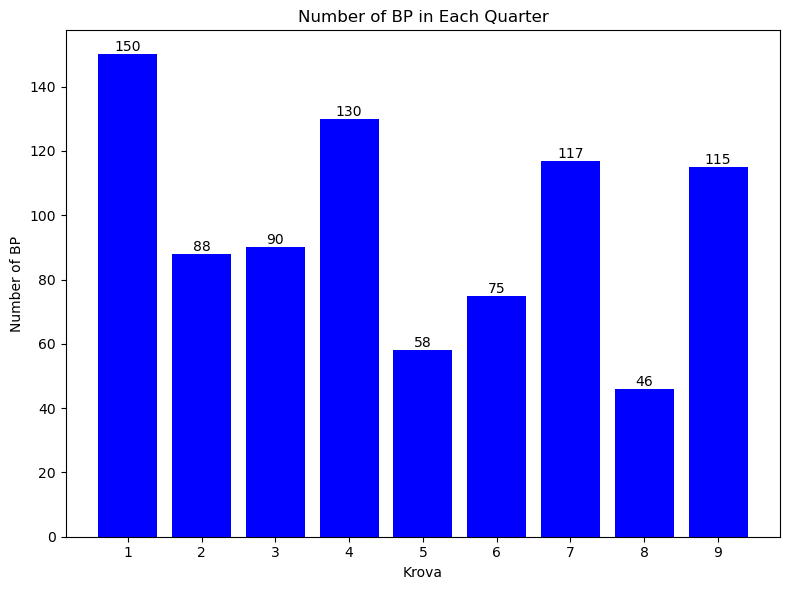

In [41]:
# Grouping by 'krova' and counting occurrences
bp_count_in_q = bp_in_q['krova'].value_counts().reset_index()
bp_count_in_q.columns = ['krova', 'count']
plot_bar_chart(bp_count_in_q['krova'], bp_count_in_q['count'], 'Number of BP in Each Quarter', 'Krova', 'Number of BP')

#### Which Quarter has more BP in total length

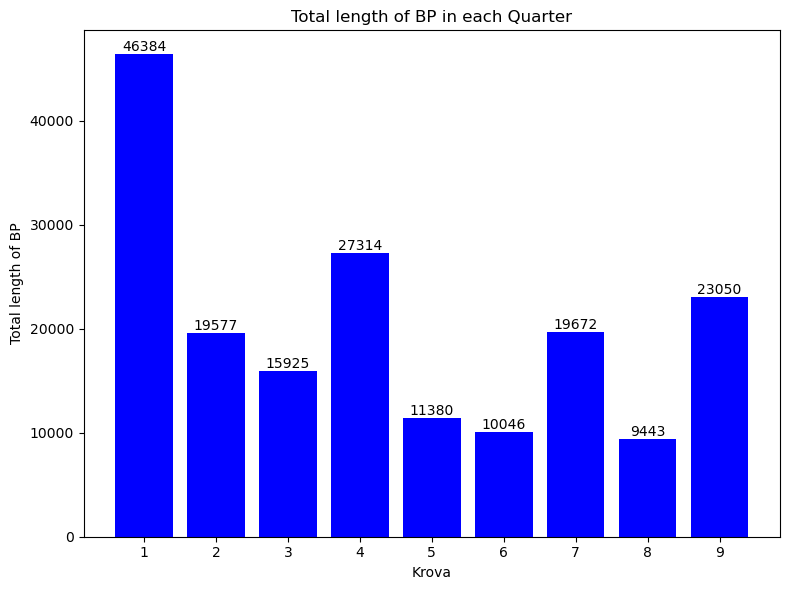

In [42]:
bp_sum_df = pd.DataFrame(bp_in_q.groupby('krova').bp_length.sum())
bp_sum_df.bp_length = bp_sum_df.bp_length.astype('int32')

plot_bar_chart(bp_sum_df.index, bp_sum_df['bp_length'], 'Total length of BP in each Quarter', 'Krova', 'Total length of BP')


Conclusions:

Quarter 1 has the highest number of individual BP and the most BP length by more than twice the second place.<br>
Quarter 4 and 9 are second and third respectively.

I would expect to see Quarter 1 to have the least amount of accidents of all the quarters.

---

#### Plotting number of Micro Mobility accidents in each Quarter

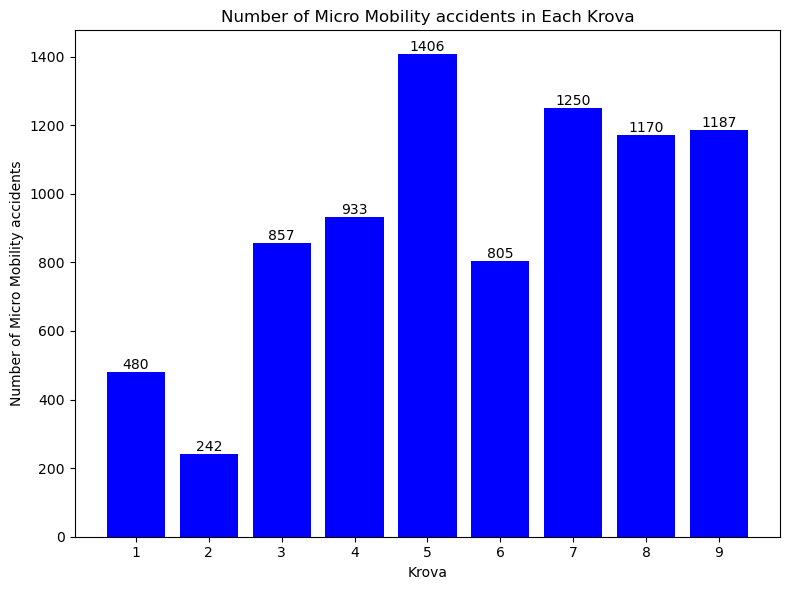

In [43]:
mm_accidents_count_krova = pd.DataFrame(i_m_h_ta_mm_quarters_gdf.groupby('krova').provider_and_id.nunique()).reset_index()
plot_bar_chart(mm_accidents_count_krova['krova'], mm_accidents_count_krova['provider_and_id'], 'Number of Micro Mobility accidents in Each Krova', 'Krova', 'Number of Micro Mobility accidents')

# mm_accidents_count_krova = i_m_h_ta_mm_quarters_gdf['krova'].value_counts().reset_index()
# plot_bar_chart(mm_accidents_count_krova['krova'], mm_accidents_count_krova['count'], 'Number of Micro Mobility accidents in Each Krova', 'Krova', 'Number of Micro Mobility accidents')

Conclusions:

We see that Quarter 1 does not have the lowest number of accidents, it is the second place.<br>
Quarter 2 has the lowest by a large margine

The quarter with the highest number of MM accidents is 5.

---

#### Plotting number of accidents that are not Micro Mobility in each quarter

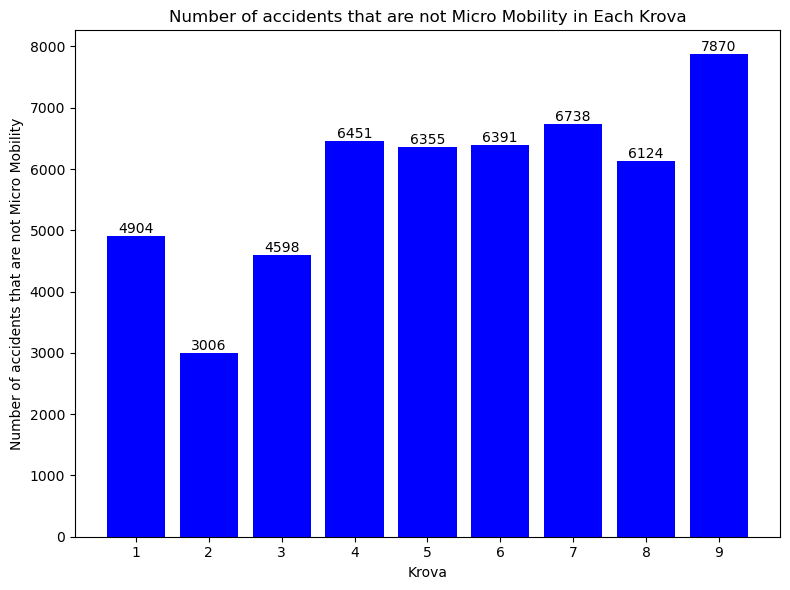

In [44]:
no_mm_accidents_count_krova = pd.DataFrame(i_m_h_ta_no_mm_quarters_gdf.groupby('krova').provider_and_id.nunique()).reset_index()
plot_bar_chart(no_mm_accidents_count_krova['krova'], no_mm_accidents_count_krova['provider_and_id'], 'Number of accidents that are not Micro Mobility in Each Krova', 'Krova', 'Number of accidents that are not Micro Mobility')

# no_mm_accidents_count_krova = i_m_h_ta_no_mm_quarters_gdf['krova'].value_counts().reset_index()
# plot_bar_chart(no_mm_accidents_count_krova['krova'], no_mm_accidents_count_krova['counts'], 'Number of accidents that are not Micro Mobility in Each Krova', 'Krova', 'Number of accidents that are not Micro Mobility')



Conclusion:

Quarter 9 has the highest number of accidents that are not micro mobility

Quarter 1 has the 4th lowest.

The lowest is Quarter 2 by a large difference to the second place Q 3 by around 30%.

---

#### Plotting number of streets in each Quarter

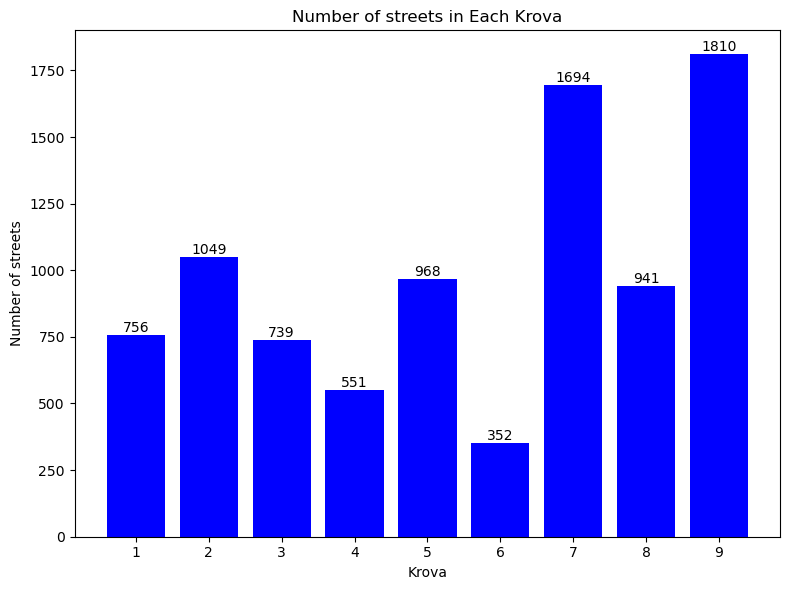

In [45]:
streets_in_krova = streets_in_q['krova'].value_counts().reset_index()
plot_bar_chart(streets_in_krova['krova'], streets_in_krova['count'], 'Number of streets in Each Krova', 'Krova', 'Number of streets')

#### Plotting total length of streets in each Quarter

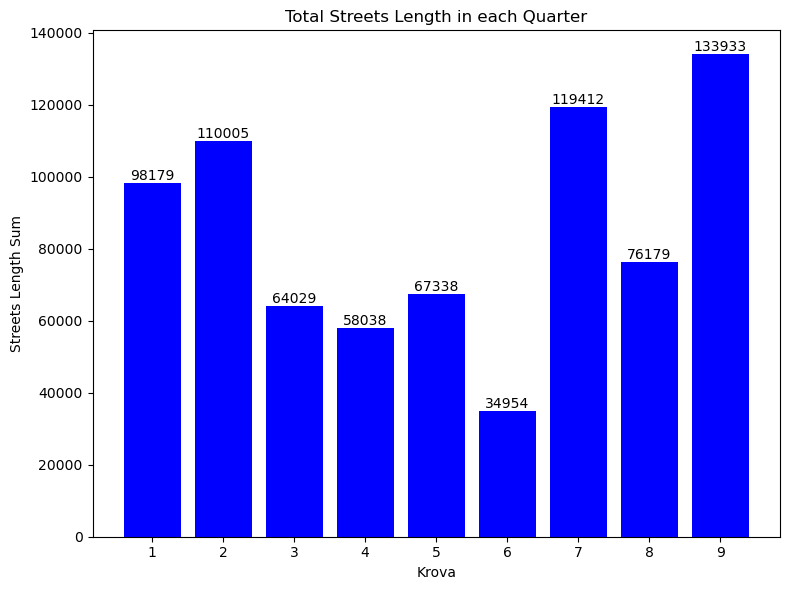

In [46]:
streets_length_sum_df = pd.DataFrame(streets_in_q.groupby('krova').street_length.sum())
streets_length_sum_df.street_length = streets_length_sum_df.street_length.astype('int32')
plot_bar_chart(streets_length_sum_df.index, streets_length_sum_df['street_length'], 'Total Streets Length in each Quarter', 'Krova', 'Streets Length Sum')

#### Plotting total streets length in relation to quarter area

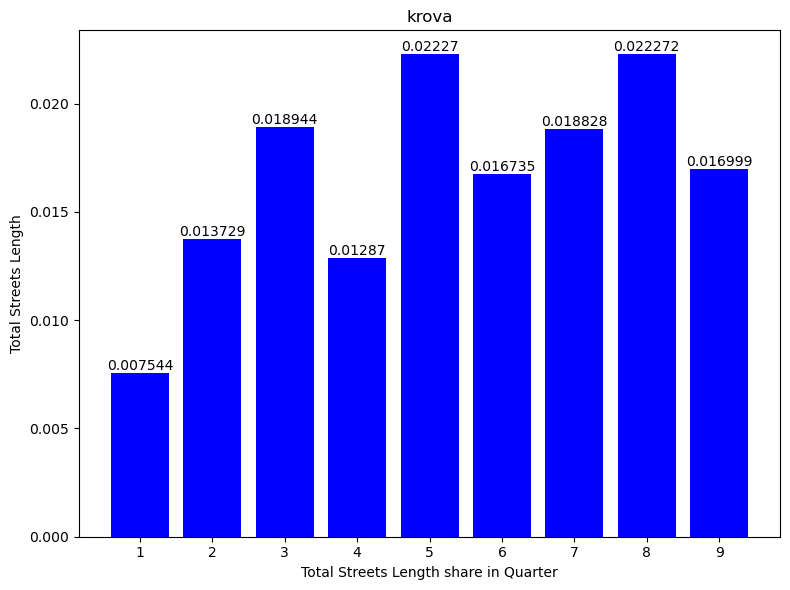

In [47]:
krova_values = streets_in_krova.sort_values(by='krova')['krova'].values
street_total_length_krova_area_ratio_ls = (streets_length_sum_df['street_length'].to_list()/ ta_q.sort_values(by='krova').area).to_list()
total_length_streets_krova_share = pd.DataFrame(street_total_length_krova_area_ratio_ls,columns=['street_ln_share_in_q'], index=krova_values)

plot_bar_chart(total_length_streets_krova_share.index, total_length_streets_krova_share['street_ln_share_in_q'], 'krova', 'Total Streets Length share in Quarter','Total Streets Length',6 )

#### Plotting number of BP in relation to Quarter area

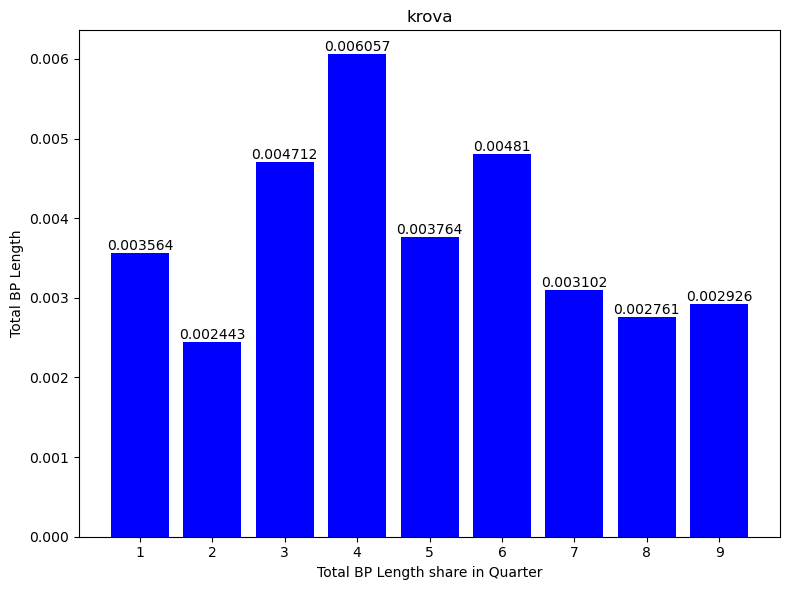

In [48]:
krova_values = streets_in_krova.sort_values(by='krova')['krova'].values
bp_total_length_krova_area_ratio_ls = (bp_sum_df['bp_length'].to_list()/ ta_q.sort_values(by='krova').area).to_list()
bp_total_length_krova_area_ratio_ls
bp_total_length_krova_share = pd.DataFrame(bp_total_length_krova_area_ratio_ls,columns=['bp_ln_share_in_q'], index=krova_values)

plot_bar_chart(bp_total_length_krova_share.index, bp_total_length_krova_share['bp_ln_share_in_q'], 'krova', 'Total BP Length share in Quarter','Total BP Length',6 )

#### Plotting Number of BP in relation to number of streets in each quarter

#### Plotting BP total length in relation to Streets total length in each quarter

In [49]:
mm_accident_share = pd.DataFrame((mm_accidents_count_krova['provider_and_id']/mm_accidents_count_krova['provider_and_id'].sum()))
mm_accident_share.columns = ['mm_accident_share']
mm_accident_share

mm_accident_share
0           0.057623
1           0.029052
2           0.102881
3           0.112005
4           0.168788
5           0.096639
6           0.150060
7           0.140456
8           0.142497

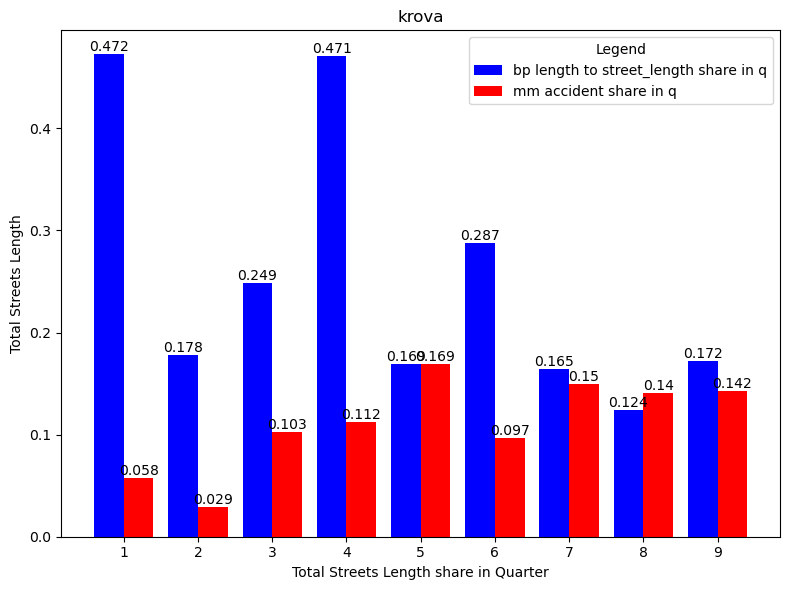

In [51]:
krova_values = bp_in_q.sort_values(by='krova')['krova'].unique()
bp_total_length_street_length_in_q_ratio_ls = (bp_sum_df['bp_length']/streets_length_sum_df['street_length']).to_list()
bp_length_to_street_length_share = pd.DataFrame(bp_total_length_street_length_in_q_ratio_ls,columns=['bp_ln_ratio_street_ln'], index=krova_values)

plot_bar_chart_2(krova_values, bp_length_to_street_length_share['bp_ln_ratio_street_ln'],mm_accident_share['mm_accident_share'], 'krova', 'Total Streets Length share in Quarter','Total Streets Length', 'bp length to street_length share in q','mm accident share in q',3 )

#### Plotting avg street width in each quarter

#### Plotting accidents severity for MM and no MM in each quarter.

#### Plotting number of accidents per quarter through the years.

#### **Compare Quarter Area:**

In [52]:
max_accidents_in_all_krova_and_year  = i_m_h_ta_quarters_gdf.groupby(['krova', 'accident_year']).provider_and_id.nunique()
# max_accidents_in_all_krova_and_year  = i_m_h_ta_quarters_gdf.groupby(['krova','accident_year']).count().max()
max_accidents_in_all_krova_and_year

krova  accident_year
1      2013             608
       2014             510
       2015             571
       2016             505
       2017             505
                       ... 
9      2020             543
       2021             562
       2022             570
       2023             542
       2024             207
Name: provider_and_id, Length: 108, dtype: int64

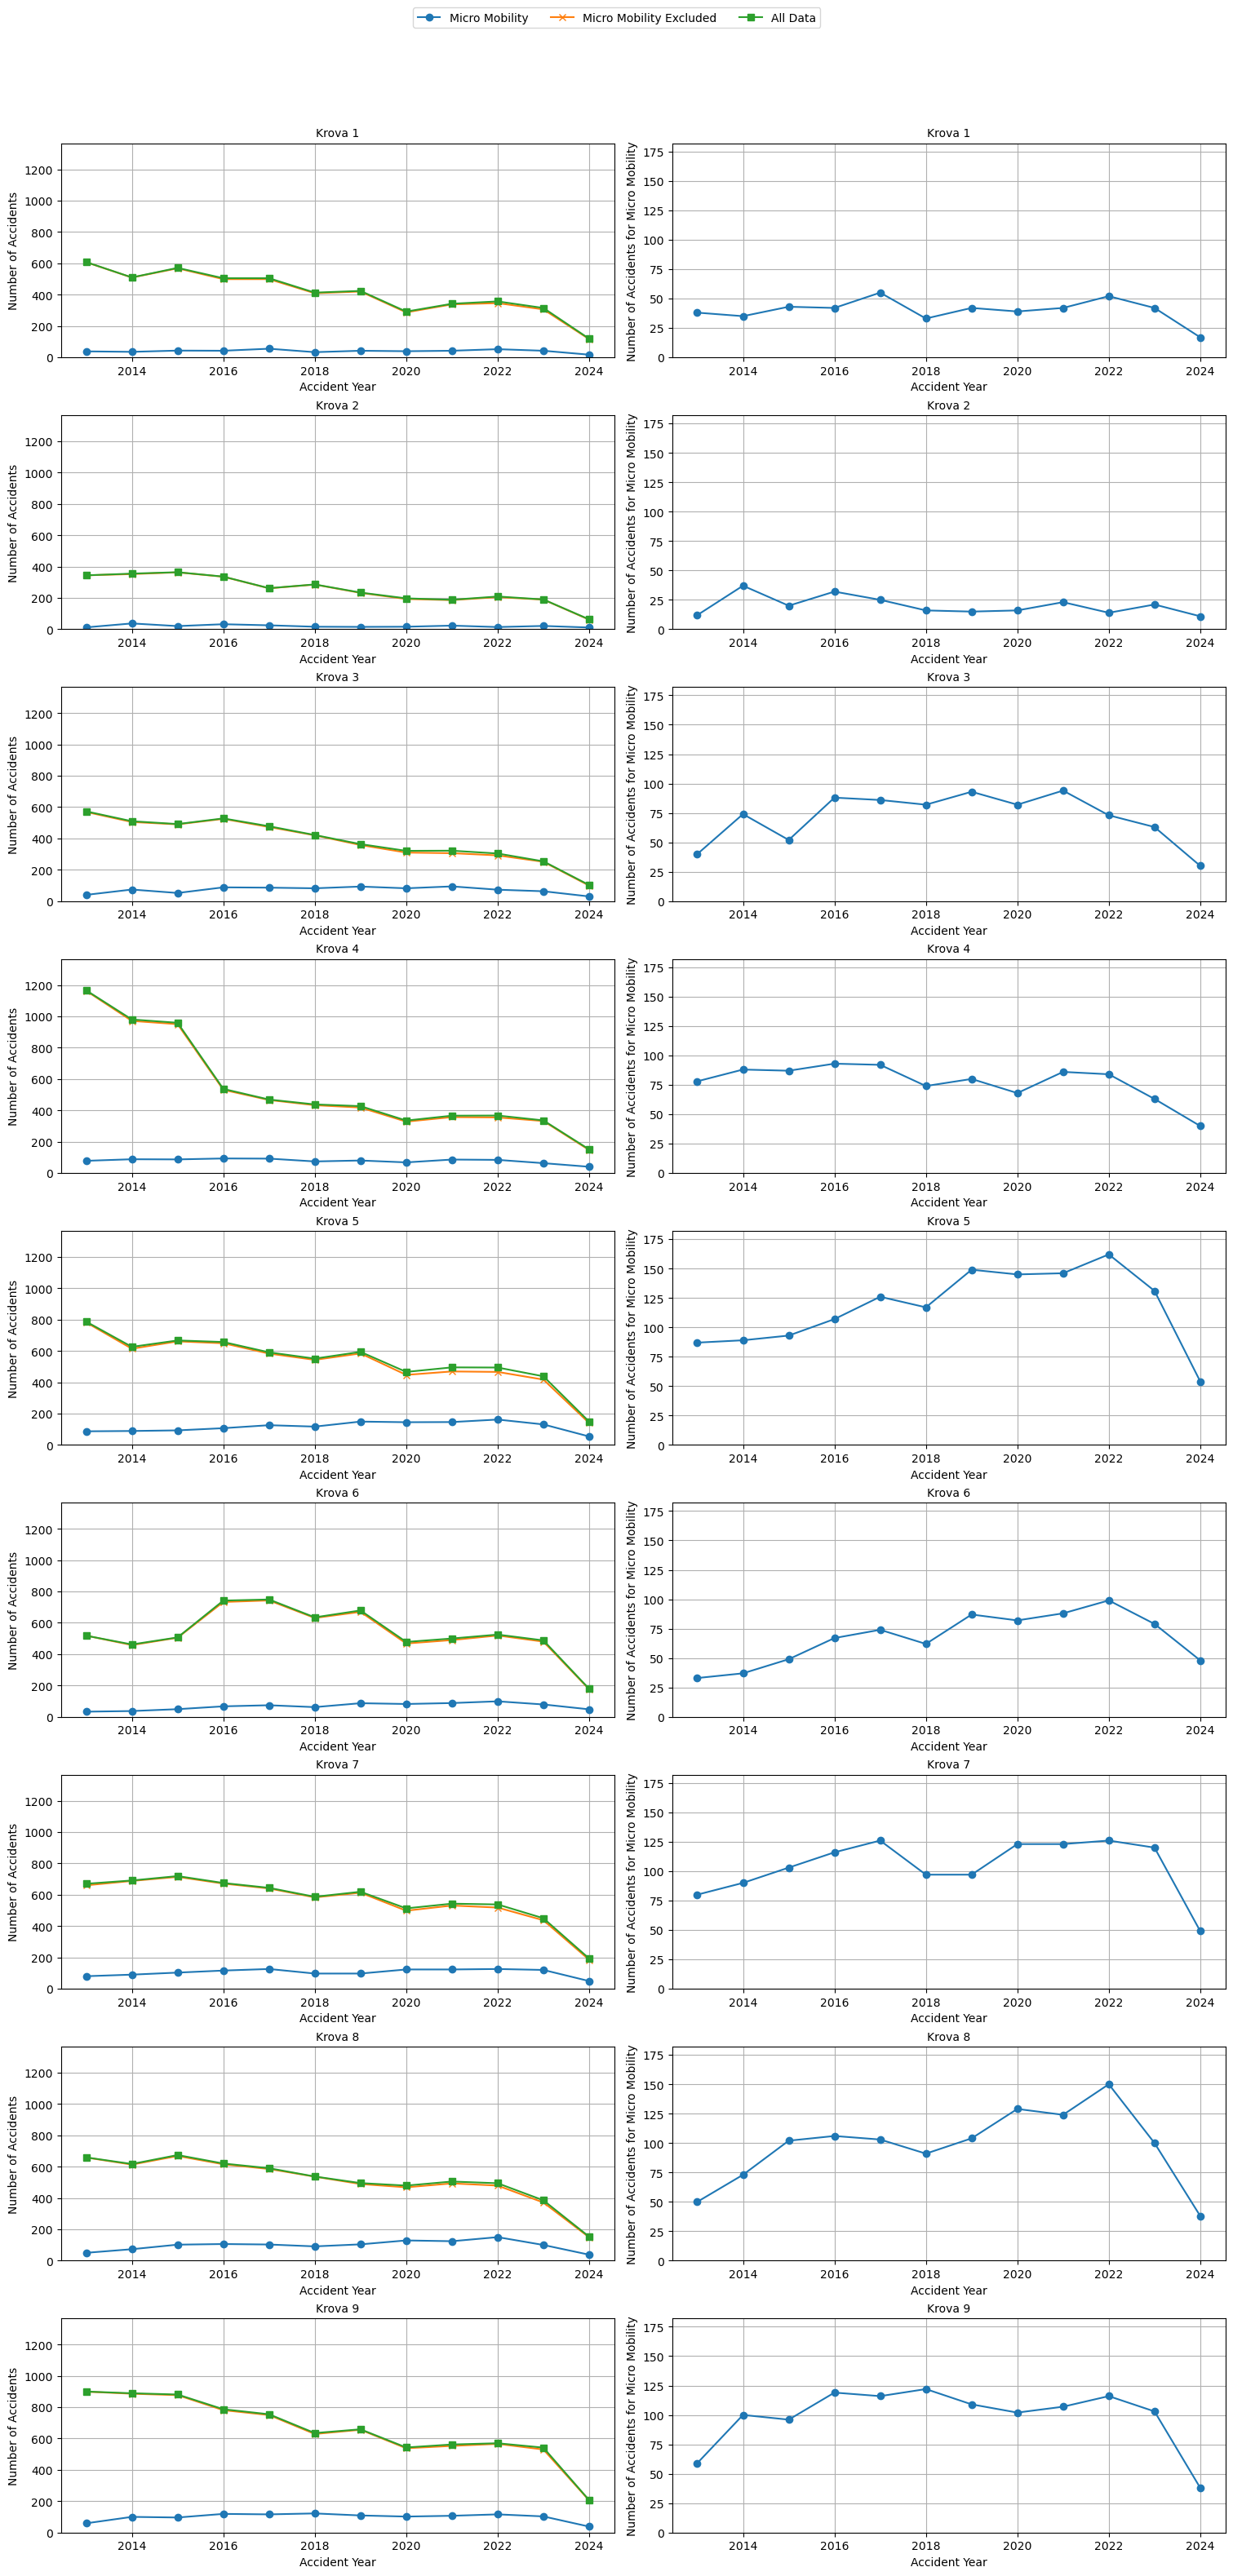

In [53]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Group data
i_m_h_ta_q_gb_krova = i_m_h_ta_quarters_gdf.groupby(['krova', 'accident_year']).provider_and_id.nunique().reset_index(name='counts')
# i_m_h_ta_q_gb_krova = i_m_h_ta_quarters_gdf.groupby(['krova', 'accident_year'])..size().reset_index(name='counts')
i_m_h_ta_no_mm_q_gb_krova = i_m_h_ta_no_mm_quarters_gdf.groupby(['krova', 'accident_year']).provider_and_id.nunique().reset_index(name='counts')
# i_m_h_ta_no_mm_q_gb_krova = i_m_h_ta_no_mm_quarters_gdf.groupby(['krova', 'accident_year']).size().reset_index(name='counts')
i_m_h_ta_mm_q_gb_krova = i_m_h_ta_mm_quarters_gdf.groupby(['krova', 'accident_year']).provider_and_id.nunique().reset_index(name='counts')
# i_m_h_ta_mm_q_gb_krova = i_m_h_ta_mm_quarters_gdf.groupby(['krova', 'accident_year']).size().reset_index(name='counts')

max_accidents_in_all_krova_and_year  = i_m_h_ta_quarters_gdf.groupby(['krova', 'accident_year']).provider_and_id.nunique().max()
# max_accidents_in_all_krova_and_year  = i_m_h_ta_quarters_gdf.groupby(['krova','accident_year']).count().max().values[0]
max_accidents_in_mm_krova_and_year  = i_m_h_ta_mm_quarters_gdf.groupby(['krova', 'accident_year']).provider_and_id.nunique().max()
# max_accidents_in_mm_krova_and_year   = i_m_h_ta_mm_quarters_gdf.groupby(['krova', 'accident_year']).count().max().values[0]

# Get unique krovas
krovas = i_m_h_ta_mm_q_gb_krova['krova'].unique()

# Determine the number of plots needed
num_plots = len(krovas) * 2
num_rows = 9
num_cols = 2

# Create subplots with adjusted margins
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 30), constrained_layout=True)
axes = axes.flatten()

# Plot each krova
for idx, krova in enumerate(krovas):
    if idx < num_plots:
        # ax for plotting all lines
        ax_all = axes[idx*2]

        # ax for plotting just micro mobility
        ax_mm = axes[idx*2 +1]
        
        # Plot line for i_m_h_ta_mm_q_gb_krova
        subset_mm = i_m_h_ta_mm_q_gb_krova[i_m_h_ta_mm_q_gb_krova['krova'] == krova]
        ax_all.plot(subset_mm['accident_year'], subset_mm['counts'], marker='o', label='Micro Mobility')
        
        # Plot line for i_m_h_ta_no_mm_q_gb_krova
        subset_no_mm = i_m_h_ta_no_mm_q_gb_krova[i_m_h_ta_no_mm_q_gb_krova['krova'] == krova]
        ax_all.plot(subset_no_mm['accident_year'], subset_no_mm['counts'], marker='x', label='Micro Mobility Excluded')
        
        # Plot line for i_m_h_ta_gdf
        subset_all = i_m_h_ta_q_gb_krova[i_m_h_ta_q_gb_krova['krova'] == krova]
        ax_all.plot(subset_all['accident_year'], subset_all['counts'], marker='s', label='All Data')
        
        ax_all.set_title(f'Krova {krova}', fontsize=10)
        ax_all.set_xlabel('Accident Year')
        ax_all.set_ylabel('Number of Accidents')
        ax_all.set_ylim(0, max_accidents_in_all_krova_and_year + 200)
        ax_all.grid(True)
        ax_all.xaxis.set_major_locator(MaxNLocator(integer=True))

        ax_mm.plot(subset_mm['accident_year'], subset_mm['counts'], marker='o', label='Micro Mobility')
        ax_mm.set_title(f'Krova {krova}', fontsize=10)
        ax_mm.set_xlabel('Accident Year')
        ax_mm.set_ylabel('Number of Accidents for Micro Mobility')
        ax_mm.set_ylim(0, max_accidents_in_mm_krova_and_year + 20)
        ax_mm.grid(True)
        ax_mm.xaxis.set_major_locator(MaxNLocator(integer=True))
    else:
        fig.delaxes(axes[idx])

# Create a single legend outside of the subplots
handles, labels = ax_all.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.05))

plt.show()


### Plotting number of accidents in relation to BP length

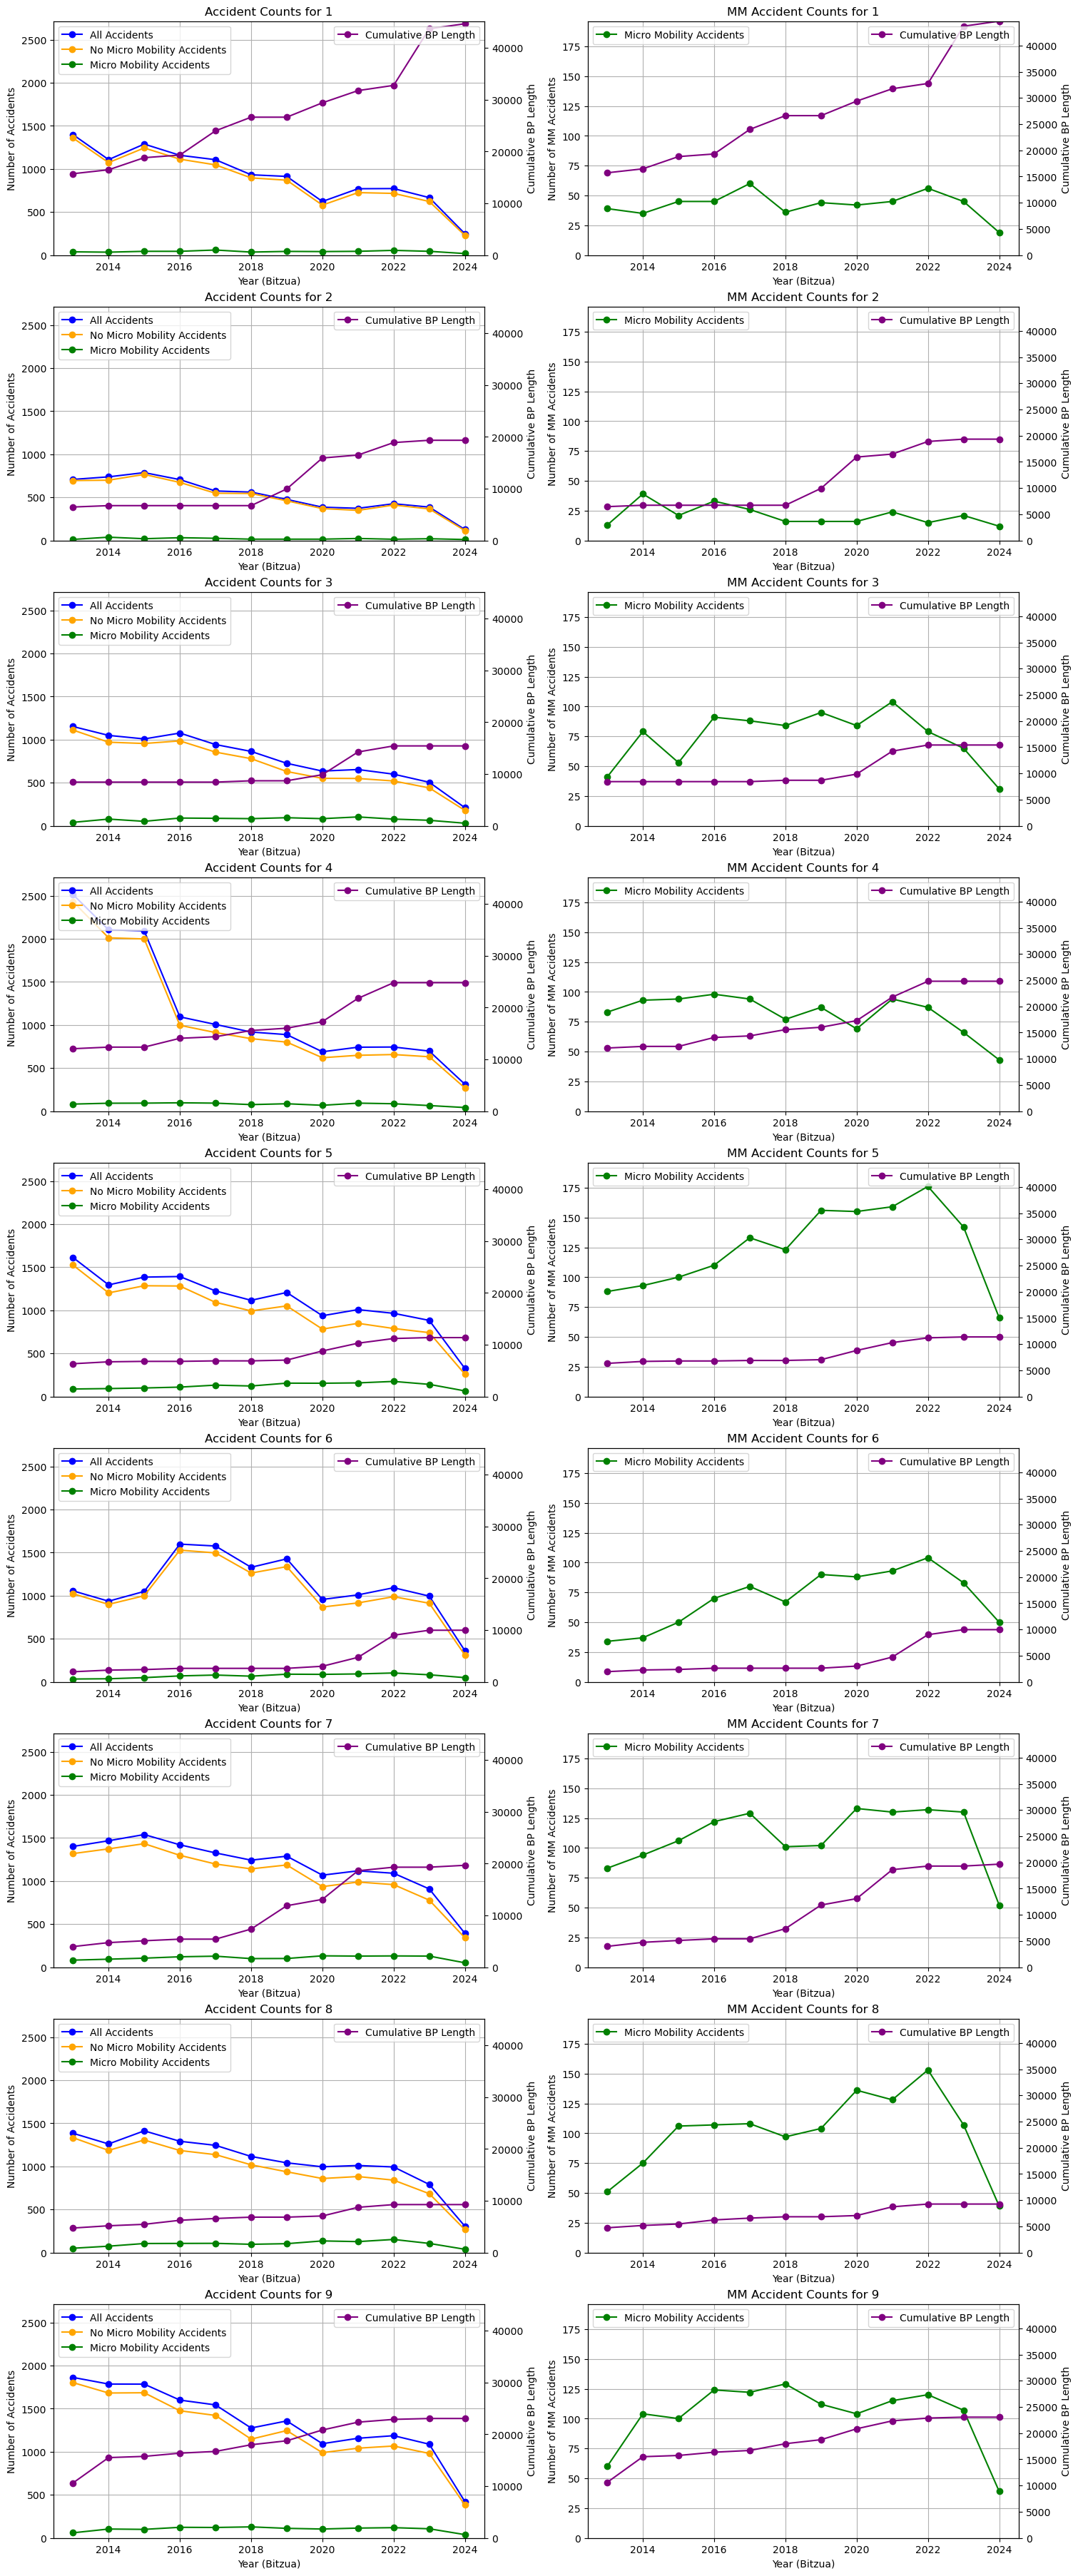

In [54]:
import matplotlib.pyplot as plt

# Calculate maximum values for y-axis limits
max_all_accidents = bp_krova_filtered['all_acc_cnt'].max()
max_mm_accidents = bp_krova_filtered['mm_acc_cnt'].max()
max_cum_bp_length = bp_krova_filtered['cum_bp_length'].max()

# Prepare the figure with 9 rows and 2 columns
fig, axs = plt.subplots(9, 2, figsize=(15, 36), constrained_layout=True)

# Flatten the 2D grid of axs for easy iteration
axs = axs.flatten()

# Colors for different types of accidents
colors = ['blue', 'orange', 'green']
labels = ['All Accidents', 'No Micro Mobility Accidents', 'Micro Mobility Accidents']

# Iterate over each unique city quarter
for i, quarter in enumerate(bp_krova_filtered.index.get_level_values('krova').unique()):
    if i < len(axs) // 2:  # Ensure we don't exceed the number of available subplots
        # Extract data for this city quarter
        data = bp_krova_filtered.loc[quarter]
        
        # First plot in the row
        ax1 = axs[2 * i]
        ax1.plot(data.index.get_level_values('bitzua'), data['all_acc_cnt'], 'o-', color=colors[0], label=labels[0])
        ax1.plot(data.index.get_level_values('bitzua'), data['no_mm_acc_cnt'], 'o-', color=colors[1], label=labels[1])
        ax1.plot(data.index.get_level_values('bitzua'), data['mm_acc_cnt'], 'o-', color=colors[2], label=labels[2])
        ax1.set_title(f'Accident Counts for {quarter}')
        ax1.set_xlabel('Year (Bitzua)')
        ax1.set_ylabel('Number of Accidents')
        ax1.set_ylim(0, max_all_accidents + 200)
        ax1.legend(loc='upper left')
        ax1.grid(True)
        # Create a secondary y-axis for cum_bp_length
        ax1_right = ax1.twinx()
        ax1_right.plot(data.index.get_level_values('bitzua'), data['cum_bp_length'], 'o-', color='purple', label='Cumulative BP Length')
        ax1_right.set_ylabel('Cumulative BP Length')
        ax1_right.set_ylim(0, max_cum_bp_length + 500)
        ax1_right.legend(loc='upper right')
        
        # Second plot in the row
        ax2 = axs[2 * i + 1]
        ax2.plot(data.index.get_level_values('bitzua'), data['mm_acc_cnt'], 'o-', color=colors[2], label=labels[2])
        ax2.set_title(f'MM Accident Counts for {quarter}')
        ax2.set_xlabel('Year (Bitzua)')
        ax2.set_ylabel('Number of MM Accidents')
        ax2.set_ylim(0, max_mm_accidents + 20)
        ax2.legend(loc='upper left')
        ax2.grid(True)

        # Create a secondary y-axis for cum_bp_length
        ax2_right = ax2.twinx()
        ax2_right.plot(data.index.get_level_values('bitzua'), data['cum_bp_length'], 'o-', color='purple', label='Cumulative BP Length')
        ax2_right.set_ylabel('Cumulative BP Length')
        ax2_right.set_ylim(0, max_cum_bp_length)
        ax2_right.legend(loc='upper right')

# Hide any unused subplots
for j in range(2 * i + 2, len(axs)):
    fig.delaxes(axs[j])

# Display the plot
plt.show()
